# Benchmarking Geral

* `Objetivo:` Avaliar a classificação de séries temporais usando 3 diferentes abordagens, incluindo nossa hipótese, de codificar séries temporais através do Gráfico de Recorrência;

* `Cenário Comparativo`: 
    - <u>Dados:</u> Considerando os dados estabelecidos no *Benchmarking 1*;
        * *Detalhes:* Base REDD, baixa Frequência, Resid. 3, com 9 aparelhos (4k amostras treino/4k teste);
        * *Amostras:* Blocos de 1 minuto e 30 segundos (90 segundos - 30 'chunks', dado delay *3s*) de cada medição;
    
    - <u>Atributos *(Feature Space)*:</u> representação vetorial das amostras;
        1. **Abordagem Estatística (Benchmarking 1)**: Média, Desvio Padrão, Máximo, Energia Total, Hora do Dia e Temperatura Ambiente (zerado, neste caso, pois não foi disponibilizado pelos autores); 
        2. **Abordagem GAF (Benchmarking 2)**: Representação visual da amostra, através do algoritmo *Wang and Oates’[20]/Gramian Angular Field Matrices (GAF)*, e subsequente *embedding* com uma Rede Neural com arquitetura VGG16;
        3. **Abordagem RP (Hipótese 1)**: Nossa hipótese, converter a amostra em uma representação visual com a técnica de Gráfico de Recorrência (RP, do inglês *Recurrence Plot*); seguindo o *Benchmarking 2*, é realizado o *embedding* da imagem resultante com uma Rede Neural com arquitetura VGG16.
        4. **Abordagem RP+RQA (Hipótese 2)**: A partir do RP, extrair métricas de RQA, as quais alimentarão o classificador de cargas.
        
    - <u>Método de Classificação:</u> Rede Neural Multi-camadas (MLP, sem hiperparametrização - pacote [Scikit-lean](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier));
    
    - <u>Métrica(s):</u> uma vez que o problema irá ser tratado como classificação multi-rótulo, irão ser adotadas as seguintes métricas (via pacote [Scikit-learn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html))
        * Classificaton Report, contendo:
            * Acurácia;
            * Precisão;
            * Recall;
            * F1-score;
            * Hamming Loss;
            * Suporte (0/1);
        * Matriz de confusão.

# Configurando ambiente e parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=False)
from matplotlib.image import imsave
import pandas as pd
import pickle as cPickle
import os, sys, cv2
from math import *
from pprint import pprint
from tqdm import tqdm_notebook, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from glob import glob
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *

from pyts.image import RecurrencePlot, GramianAngularField

REDD_RESOURCES_PATH = 'datasets/REDD'
SEED = 33

BENCHMARKING1_RESOURCES_PATH = 'benchmarkings/cs446 project-electric-load-identification-using-machine-learning/'
BENCHMARKING2_RESOURCES_PATH = 'benchmarkings/Imaging-NILM-time-series/'
HYPOTHESIS_RESOURCES_PATH = 'datasets/hipotese1-recurrenceplot-vggembedding/'

sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, ''))
sys.path.append(os.path.join(BENCHMARKING2_RESOURCES_PATH, ''))
sys.path.append(os.path.join(HYPOTHESIS_RESOURCES_PATH, ''))

from serie2QMlib import *

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
tf.__version__

'2.0.0'

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
# tf.debugging.set_log_device_placement(False)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            

#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carregando os dados

In [7]:
datapath = os.path.join(REDD_RESOURCES_PATH, 'low_freq/house_3/')

dataset_size = 404107

fileprefix = 'channel_'

# devices to be used in training and testing
use_idx = np.array([3,4,6,7,10,11,13,17,19])

label_columns_idx = ["APLIANCE_{}".format(i) for i in use_idx]

appliance_labels = [
    "Electronics", 
    "Refrigerator", 
    "Dishwasher",
    "Furnace", 
    "Washer Dryer 1", 
    "Washer Dryer 2", 
    "Microwave", 
    "Bathroom GFI",
    "Kitchen Outlets"
]

# Select some appliances for paper
valid_appliances = [
    "Refrigerator", "Dishwasher", "Furnace", "Wash Dryer 1", "Microwave"
]
valid_appliances_index = [
    1, 2, 3, 4, 6
]
#np.array(appliance_labels)[valid_appliances_index])

## Dados da base REDD

Collection REDD data (Low frequency, House 3)...


Iter: 0 / Device: 3-Electronics
Iter: 1 / Device: 4-Refrigerator
Iter: 2 / Device: 6-Dishwasher
Iter: 3 / Device: 7-Furnace
Iter: 4 / Device: 10-Washer Dryer 1
Iter: 5 / Device: 11-Washer Dryer 2
Iter: 6 / Device: 13-Microwave
Iter: 7 / Device: 17-Bathroom GFI
Iter: 8 / Device: 19-Kitchen Outlets


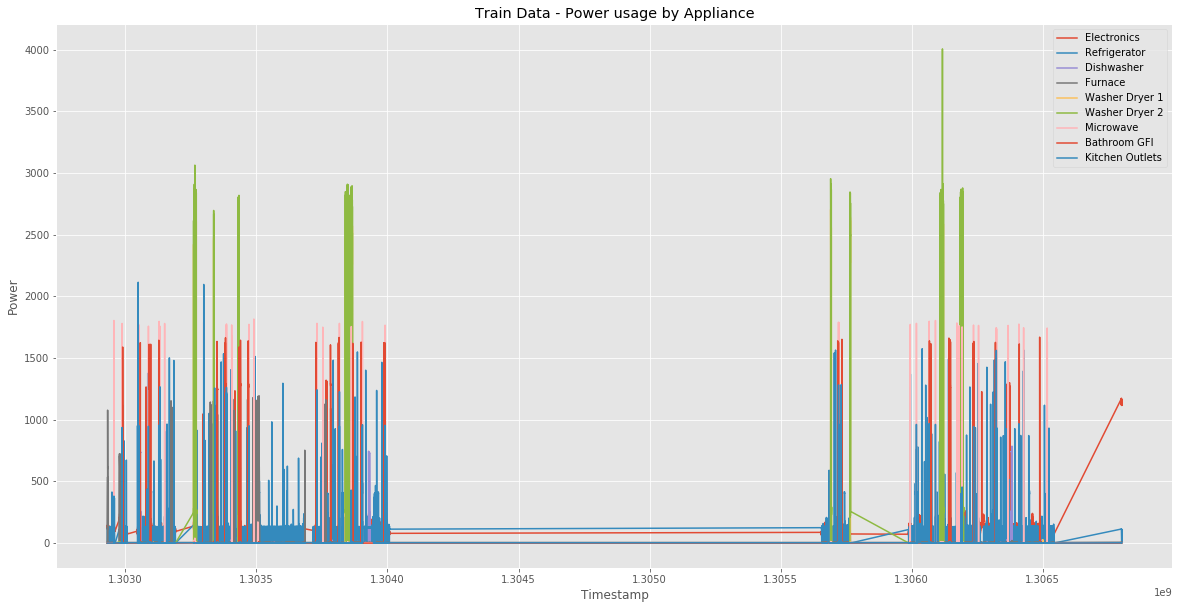

In [15]:
print("Collection REDD data (Low frequency, House 3)...")

device_timer = np.zeros(shape=(dataset_size, len(appliance_labels)))
device_power = np.zeros(shape=(dataset_size, len(appliance_labels)))
total_device_power = np.zeros(shape=(dataset_size))

# For each device (index), do...
uidx = 0
fig = plt.figure(figsize=(20, 10))
for device in tqdm_notebook(range(0, 20)):
    
    # If the device is in our list of interest..
    if (device in use_idx):
        
        # Load energy data
        channel = device + 3
        filename = 'channel_'+ str(channel) +'.dat'
        filepath = datapath + filename

        # x = timestamp / y = energy
        xtemp, ytemp = np.loadtxt(filepath, unpack=True)

        print('Iter: {} / Device: {}-{}'.format(uidx, device, appliance_labels[uidx]))
        device_timer[:, uidx] = xtemp
        device_power[:, uidx] = ytemp
        total_device_power += ytemp
        
        plt.plot(device_timer[:,uidx], device_power[:,uidx])

        uidx = uidx + 1     

plt.title('Train Data - Power usage by Appliance')
plt.legend([ '{}'.format(a) for a in appliance_labels])
plt.xlabel('Timestamp')
#plt.xlim(xtemp[0], xtemp[dataset_size])
plt.ylabel('Power')
plt.show()


## Pré-processamento (série em janelas)

In [28]:
sys.path.append(os.path.join(BENCHMARKING1_RESOURCES_PATH, 'src'))
from MLData import createInstances

################################################################
# create the instances and labels from the training data
classifier = 3 # 1 - Naive Bayes, 2 - Regression, 3 - SVM, 4 - Linear Discriminant Analysis, 5 - Random Forest Classifier

instances, labels, labels_binary, power_chunks = createInstances(
    total_device_power, device_timer, device_power,  np.zeros(shape=(dataset_size)),
    classifier,
    timewindow
)

instances: 13470


In [29]:
# Informacoes estatisticas (benchmarking 1)
instances.shape

(13470, 7)

In [30]:
power_chunks.shape

(13470, 30)

In [35]:
labels.shape

(13470,)

In [36]:
labels_binary.shape

(13470, 9)

In [32]:
# Data persistence
np.save('datasets/instances.npy', instances)
np.save('datasets/labels.npy', labels)
np.save('datasets/labels_binary.npy', labels_binary)
np.save('datasets/power_chunks.npy', power_chunks)

# Carregando dados persistidos

In [8]:
#instances = np.load('datasets/instances.npy')
#labels = np.load('datasets/labels.npy')
labels_binary = np.load('datasets/labels_binary.npy')
power_chunks = np.load('datasets/power_chunks.npy')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    power_chunks, labels_binary,
    #stratify = labels_binary,
    random_state=SEED, test_size=0.1, shuffle=True
)

# OPTIONAL: Filtering appliances for paper
y_train = y_train[:, valid_appliances_index]
y_test = y_test[:, valid_appliances_index]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("---")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12123, 30)
y_train shape: (12123, 5)
---
X_test shape: (1347, 30)
y_test shape: (1347, 5)


# Avaliando Classificadores

## Funções Auxiliares

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# def metrics(test, predicted):
#     return acc, prec, rec, f1, f1m, hl

def plot_predicted_and_ground_truth(test, predicted):
    #import matplotlib.pyplot as plt
    plt.plot(predicted.flatten(), label = 'pred')
    plt.plot(test.flatten(), label= 'Y')
    plt.show();
    return

def classification_report(y_test, y_pred, labels = None):
    
    final_performance = []
    
    for i in range(y_test.shape[1]):
    
        test = y_test[:, i]
        predicted = y_pred[:, i]
        #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
        acc = accuracy_score(test, predicted)
        prec = precision_score(test, predicted)
        rec = recall_score(test, predicted)    
        f1 = f1_score(test, predicted)
        f1m = f1_score(test, predicted, average='macro')
        hl = hamming_loss(test, predicted)   
        auc_ = roc_auc_score(test, predicted)
        y_i = y_test[:, i]
        supp_0 = y_i[y_i==0].shape[0]
        supp_1 = y_i[y_i==1].shape[0]

        final_performance.append([
            labels[i] if labels is not None else label_columns_idx[i], 
            round(acc*100, 2), 
            round(prec*100, 2), 
            round(rec*100, 2), 
            round(f1*100, 2), 
            round(f1m*100, 2),
            round(hl, 2),
            round(auc_, 2),
            supp_0,
            supp_1
        ])

    print("CLASSIFIER PERFORMANCE BY APPLIANCE (LABEL):")
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

    print("")
    print("OVERALL AVERAGE PERFORMANCE:")
    display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON), BY APPLIANCE:")
    
    cms = multilabel_confusion_matrix(y_test, y_pred)
    for i, a in enumerate(labels):
        print("")
        print(" - {}:".format(a))
        print(cms[i])
    #print(, labels= appliance_labels)


In [11]:
from time import time

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

from keras_tqdm import TQDMNotebookCallback
tqdm_callback = TQDMNotebookCallback()
setattr(tqdm_callback,'on_train_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_train_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_begin',lambda x,y:None)
setattr(tqdm_callback,'on_test_batch_end',lambda x,y:None)
setattr(tqdm_callback,'on_test_begin', lambda x:None)
setattr(tqdm_callback,'on_test_end', lambda x:None)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_macro(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [12]:
from sklearn.pipeline import Pipeline
from pyts.image import RecurrencePlot, GramianAngularField
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

import numpy as np
import random as rn
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

def calculate_metrics(estimator, X_test, y_test):
    y_pred = np.array(estimator.model.predict(X_test).round()) # TODO: corrigir '.model' (https://github.com/keras-team/keras/issues/9331)
    return (
        accuracy_score(y_test, y_pred), 
        precision_score(y_test, y_pred, average='macro'), 
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='micro'),
        f1_score(y_test, y_pred, average='macro')
    )

def global_scorer(estimator, X_test, y_test):
    acc, prec, rec, f1, f1m = calculate_metrics(estimator, X_test, y_test)
    return acc, prec, rec, f1, f1m

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    acc, prec, rec, f1, f1m = global_scorer(model, X_test, y_test)
    return [acc, prec, rec, f1, f1m]

#label_encoder = LabelEncoder()

kfold = StratifiedKFold(
    n_splits=10, 
    shuffle=True, 
    random_state= 33
)

# Deep Learning

## Funções Auxiliares

In [13]:
import shutil
from tensorflow.keras import optimizers

class ImageProcessing():
    def __init__(self, image_size_px = 128, Y = None):
        self.image_size_px = image_size_px
        
    def fit(self, images, Y = None, mode = "train"):
        return self

    def transform(self, images, Y = None, mode = 'train'):
        processed_images = []
        try:
#             for idx, image in tqdm_notebook(enumerate(images), total=len(images)):
#                 img = np.stack((image,) * 3, -1)
#                 processed_images.append(img/255)
            if os.path.isdir(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp")):        
                shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            os.makedirs(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
                
            for idx, image in tqdm_notebook(enumerate(images)):
#                 labels = Y[idx, :].astype('str').tolist()
#                 labels_str = ''.join(labels)
                image_path = os.path.join( 
                        HYPOTHESIS_RESOURCES_PATH, "temp",
                        "{}_{}_color.png".format(idx, mode) 
                    )
                imsave(
                    image_path, 
                    arr=image
                )
                # Reading image in 3channel RGB mode
                img = keras_image.load_img( image_path, target_size=(self.image_size_px, self.image_size_px ,3))
                img = keras_image.img_to_array(img)
                img = img/255                
                #img = MinMaxScaler(feature_range=(-1, 1)).fit_transform(img.reshape(1,-1)).reshape(img.shape)
                processed_images.append(img)
            
            shutil.rmtree(os.path.join(HYPOTHESIS_RESOURCES_PATH, "temp"))
            
        except Exception as err:
            print('ImageProcessing.transform(): {}'.format(err))
            
        return np.array(processed_images)
        #return processed_images

    def fit_transform(self, images, Y = None, mode = 'train'):
        self.fit(images)
        return self.transform(images, Y, mode)

#################################### MODELOS 
def cnn_model(output_layer_length = len(valid_appliances)):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_layer_length, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_macro])
    
    return model

def cnn_model_appliance(loss_function = 'binary_crossentropy'):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss=[loss_function], metrics=['accuracy',f1_macro])
    
    return model

def vgg_model_multilabel():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(len(valid_appliances), activation='softmax')(x) #final layer with softmax activation
    
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(
        optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_macro]
    )
    
    return model

def vgg_model_appliance():
    base_model = VGG16(
        weights='imagenet',
        #weights = None,
        include_top=False, #imports the mobilenet model and discards the last neuron layer.
        input_shape = train_rp_images[0].shape
    ) 
    # mark loaded layers as not trainable
    for layer in base_model.layers:
        layer.trainable = False
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    
#     #x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#     x=Dense(1024,activation='relu')(x) #dense layer 2
#     x=Dense(512,activation='relu')(x) #dense layer 3
#     #output_layer = Dense(2, activation='softmax')(x) #final layer with softmax activation
    
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x) #dense layer 2
    x = Dropout(0.5)(x)
    x = Dense(64,activation='relu')(x) #dense layer 3
    x = Dropout(0.5)(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(
        inputs  = base_model.input,
        outputs = output_layer
    )    
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', f1_macro])
    
    return model

def tiled_cnn_model( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(len(valid_appliances), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
    
    return model

def tiled_cnn_model_appliance( ):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(128,128,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_macro])
    
    return model

## Converter Séries (janelas) em Imagens (GAF/RP)

In [14]:
print("Processing GAF datasets (train/test)...")
gaf_pipeline = Pipeline([
    ('gramianangularfield', GramianAngularField()),
    ('imageprocessing', ImageProcessing())
])
train_gaf_images = gaf_pipeline.fit_transform(X_train, imageprocessing__mode = "train")
test_gaf_images = gaf_pipeline.fit_transform(X_test, imageprocessing__mode = "test")

print("Processing RP datasets (train/test)...")
rp_pipeline = Pipeline([
    ('recurrenceplot', RecurrencePlot()),
    ('imageprocessing', ImageProcessing())
])
train_rp_images = rp_pipeline.fit_transform(X_train, imageprocessing__mode = "train")
test_rp_images = rp_pipeline.fit_transform(X_test, imageprocessing__mode = "test")

# # Visualizing Serie/Image
# fig = plt.figure(figsize=(2,2))
# fig.tight_layout(); # Or equivalently,  "plt.tight_layout()"
# ax = fig.add_subplot(1, 1, 1);
# ax.imshow(test_gaf_images[0], origin="lower", aspect="auto");
# ax = fig.add_subplot(1, 2, 1);
# ax.plot(list(power_chunks[0, :]), range(len(power_chunks[0, :])));
# plt.axis('off');

#del power_chunks

Processing GAF datasets (train/test)...



Processing RP datasets (train/test)...


## Amostras de Imagens Individuais

Appliance `Refrigerator`:


TypeError: Invalid shape (30,) for image data

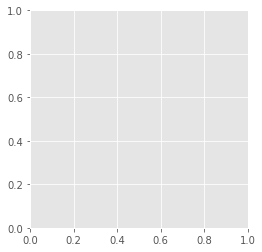

In [77]:
idx_appliance = 0

index = np.where(
    (y_train[:, idx_appliance] == 1) & 
    (y_train[:, 1] == 0) & (y_train[:, 2] == 0) &
    (y_train[:, 3] == 0) & (y_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(X_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(X_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Dishwasher`:


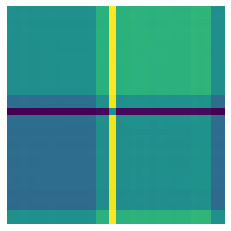

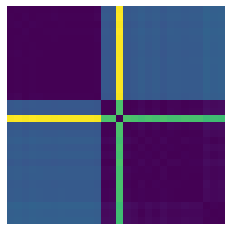

In [142]:
idx_appliance = 1

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 2] == 0) &
    (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Furnace`:


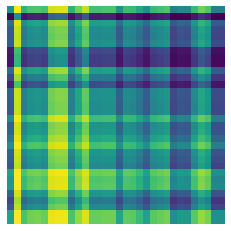

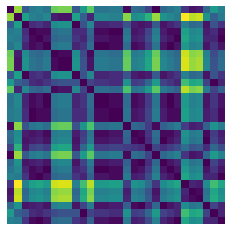

In [143]:
idx_appliance = 2

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 3] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Wash Dryer 1`:


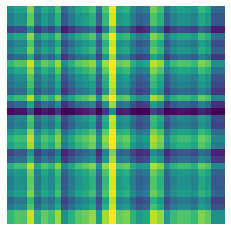

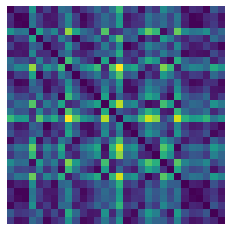

In [144]:
idx_appliance = 3

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 2] == 0) & (yh3_train[:, 4] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

Appliance `Microwave`:


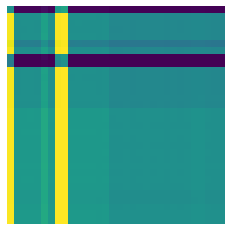

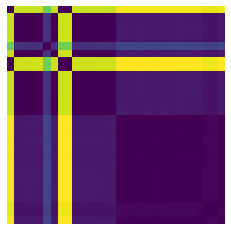

In [145]:
idx_appliance = 4

index = np.where(
    (yh3_train[:, idx_appliance] == 1) & 
    (yh3_train[:, 0] == 0) & (yh3_train[:, 1] == 0) &
    (yh3_train[:, 2] == 0) & (yh3_train[:, 3] == 0)
)[0][0]

print("Appliance `{}`:".format(valid_appliances[idx_appliance]))
fig = plt.figure()
plt.imshow(Xh3_train[index])
plt.axis('off')
plt.savefig('resources/images/gaf-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

fig = plt.figure()
plt.imshow(Xh4_train[index])
plt.axis('off')
plt.savefig('resources/images/rp-{}.png'.format(valid_appliances[idx_appliance].lower()), bbox_inches='tight', transparent=True)

## Classificador Multilabel

### GAF

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = cnn_model()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, y_train,
    validation_data=(test_gaf_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

Training GAF multilabel model...
Train on 12123 samples, validate on 1347 samples
Epoch 1/100


In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = tiled_cnn_model()#vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, y_train,
    validation_data=(test_gaf_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training GAF multilabel model...")

multiabel_gaf_model = vgg_model_multilabel()

callback = multiabel_gaf_model.fit(
    train_gaf_images, y_train,
    validation_data=(test_gaf_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_macro = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_macro = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_gaf_model.predict(test_gaf_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

### RP

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = tiled_cnn_model()#vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    train_rp_images, y_train,
    validation_data=(test_rp_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = vgg_model_multilabel()

callback = multiabel_rp_model.fit(
    train_rp_images, y_train,
    validation_data=(test_rp_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

In [ ]:
# Model fit...
print("Training RP multilabel model...")

multiabel_rp_model = cnn_model()

callback = multiabel_rp_model.fit(
    train_rp_images, y_train,
    validation_data=(test_rp_images, y_test), 
    epochs=100, 
    batch_size=32,
    verbose = 2#, callbacks = [tqdm_callback]
)

# Plot metrics...
fig = plt.figure(figsize=(13,5))
line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
plt.title("Model Train History")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

# Final report (validated on test set)
y_pred = np.array(multiabel_rp_model.predict(test_rp_images).round())
classification_report(y_test, y_pred, labels = valid_appliances)

## Classificadores Binários por Carga

In [15]:
def classification_report_appliance(y_test, y_pred, label = None):
    
    final_performance = []
    
    test = y_test
    predicted = y_pred
    #acc, prec, rec, f1, f1m, hl, supp = metrics(y_test[:, i], y_pred[:, i])
    acc = accuracy_score(test, predicted)
    prec = precision_score(test, predicted)
    rec = recall_score(test, predicted)    
    f1 = f1_score(test, predicted)
    f1m = f1_score(test, predicted, average='macro')
    hl = hamming_loss(test, predicted)   
    auc_ = roc_auc_score(test, predicted)
    y_i = y_test
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]

    final_performance = [[
        label, 
        round(acc*100, 2), 
        round(prec*100, 2), 
        round(rec*100, 2), 
        round(f1*100, 2), 
        round(f1m*100, 2),
        round(hl, 2),
        round(auc_, 2),
        supp_0,
        supp_1
    ]]

    print("CLASSIFIER PERFORMANCE {} MODEL:".format(label.upper()))
    df_metrics = pd.DataFrame(
        data = final_performance,
        columns = ["Appliance", "Accuracy", "Precision", "Recall", "F1-score", "F1-macro", "Hamming Loss", "AUC", "Support (y=0)", "Support (y=1)"]
    )
    display(df_metrics)

#     print("")
#     print("OVERALL AVERAGE PERFORMANCE:")
#     display(df_metrics.describe().round(2).loc[['mean','max','min']])
    
    print("")
    print("CONFUSION MATRIX (OFF/ON):")
    
    cms = confusion_matrix(y_test, y_pred)
    for i, a in enumerate([label]):
        print("")
        print(" - {}:".format(a))
        print(cms)

### GAF

---> Training the `Refrigerator` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 34s - loss: 0.6552 - accuracy: 0.6377 - f1_macro: 0.4268 - val_loss: 0.6378 - val_accuracy: 0.6600 - val_f1_macro: 0.4340
Epoch 2/100
12123/12123 - 29s - loss: 0.6363 - accuracy: 0.6664 - f1_macro: 0.4263 - val_loss: 0.6309 - val_accuracy: 0.6578 - val_f1_macro: 0.4383
Epoch 3/100
12123/12123 - 29s - loss: 0.6305 - accuracy: 0.6667 - f1_macro: 0.4362 - val_loss: 0.6291 - val_accuracy: 0.6607 - val_f1_macro: 0.4430
Epoch 4/100
12123/12123 - 29s - loss: 0.6262 - accuracy: 0.6694 - f1_macro: 0.4453 - val_loss: 0.6377 - val_accuracy: 0.6526 - val_f1_macro: 0.3908
Epoch 5/100
12123/12123 - 29s - loss: 0.6224 - accuracy: 0.6721 - f1_macro: 0.4469 - val_loss: 0.6239 - val_accuracy: 0.6570 - val_f1_macro: 0.4292
Epoch 6/100
12123/12123 - 29s - loss: 0.6212 - accuracy: 0.6714 - f1_macro: 0.4505 - val_loss: 0.6236 - val_accuracy: 0.6592 - val_f1_macro: 0.4449
Epoch 7/100
12123/12

Epoch 56/100
12123/12123 - 29s - loss: 0.5879 - accuracy: 0.6894 - f1_macro: 0.4752 - val_loss: 0.6062 - val_accuracy: 0.6689 - val_f1_macro: 0.4644
Epoch 57/100
12123/12123 - 29s - loss: 0.5904 - accuracy: 0.6886 - f1_macro: 0.4779 - val_loss: 0.6102 - val_accuracy: 0.6711 - val_f1_macro: 0.4497
Epoch 58/100
12123/12123 - 29s - loss: 0.5881 - accuracy: 0.6938 - f1_macro: 0.4855 - val_loss: 0.6117 - val_accuracy: 0.6652 - val_f1_macro: 0.4609
Epoch 59/100
12123/12123 - 29s - loss: 0.5841 - accuracy: 0.6904 - f1_macro: 0.4881 - val_loss: 0.6058 - val_accuracy: 0.6719 - val_f1_macro: 0.4683
Epoch 60/100
12123/12123 - 29s - loss: 0.5870 - accuracy: 0.6908 - f1_macro: 0.4806 - val_loss: 0.6219 - val_accuracy: 0.6696 - val_f1_macro: 0.4732
Epoch 61/100
12123/12123 - 29s - loss: 0.5885 - accuracy: 0.6935 - f1_macro: 0.4820 - val_loss: 0.6103 - val_accuracy: 0.6711 - val_f1_macro: 0.4942
Epoch 62/100
12123/12123 - 29s - loss: 0.5872 - accuracy: 0.6927 - f1_macro: 0.4828 - val_loss: 0.6081 - v

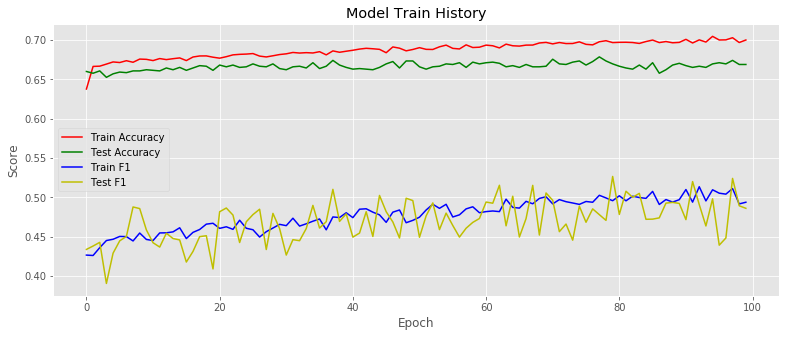

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,66.89,73.18,37.71,49.77,62.54,0.33,0.64,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[680  81]
 [365 221]]

---> Training the `Dishwasher` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.0923 - accuracy: 0.9795 - f1_macro: 8.7071e-04 - val_loss: 0.0969 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0731 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0801 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0721 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0794 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0715 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0790 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0706 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0793 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0687 - accuracy: 0.9

Epoch 54/100
12123/12123 - 29s - loss: 0.0497 - accuracy: 0.9895 - f1_macro: 0.0479 - val_loss: 0.0905 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 29s - loss: 0.0503 - accuracy: 0.9894 - f1_macro: 0.0484 - val_loss: 0.0726 - val_accuracy: 0.9837 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 29s - loss: 0.0492 - accuracy: 0.9895 - f1_macro: 0.0519 - val_loss: 0.0839 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 29s - loss: 0.0485 - accuracy: 0.9896 - f1_macro: 0.0550 - val_loss: 0.0720 - val_accuracy: 0.9852 - val_f1_macro: 0.0233
Epoch 58/100
12123/12123 - 29s - loss: 0.0516 - accuracy: 0.9892 - f1_macro: 0.0404 - val_loss: 0.0727 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 29s - loss: 0.0480 - accuracy: 0.9894 - f1_macro: 0.0484 - val_loss: 0.0889 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 60/100
12123/12123 - 29s - loss: 0.0493 - accuracy: 0.9893 - f1_macro: 0.0435 - 

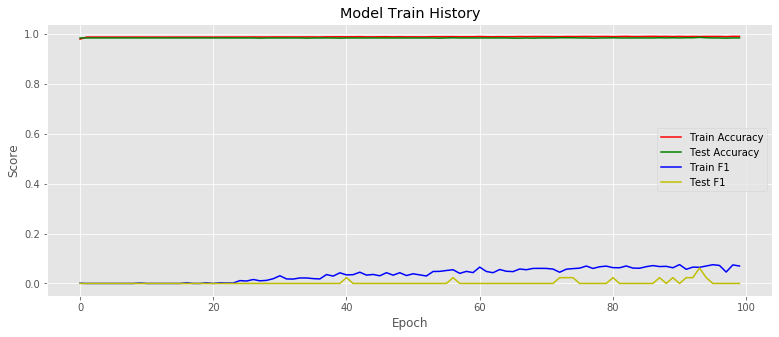

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.44,0.0,0.0,0.0,49.61,0.02,0.5,1326,21



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[1326    0]
 [  21    0]]

---> Training the `Furnace` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.1101 - accuracy: 0.9781 - f1_macro: 6.8162e-04 - val_loss: 0.0720 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0951 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0742 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0966 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0669 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0961 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0824 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0907 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0668 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0915 - accuracy: 0.98

Epoch 54/100
12123/12123 - 29s - loss: 0.0742 - accuracy: 0.9823 - f1_macro: 0.0538 - val_loss: 0.0692 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 29s - loss: 0.0739 - accuracy: 0.9818 - f1_macro: 0.0506 - val_loss: 0.0719 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 29s - loss: 0.0732 - accuracy: 0.9823 - f1_macro: 0.0580 - val_loss: 0.0697 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 29s - loss: 0.0747 - accuracy: 0.9814 - f1_macro: 0.0352 - val_loss: 0.0705 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 29s - loss: 0.0739 - accuracy: 0.9819 - f1_macro: 0.0435 - val_loss: 0.0688 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 29s - loss: 0.0737 - accuracy: 0.9814 - f1_macro: 0.0352 - val_loss: 0.0673 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 60/100
12123/12123 - 29s - loss: 0.0728 - accuracy: 0.9819 - f1_macro: 0.049

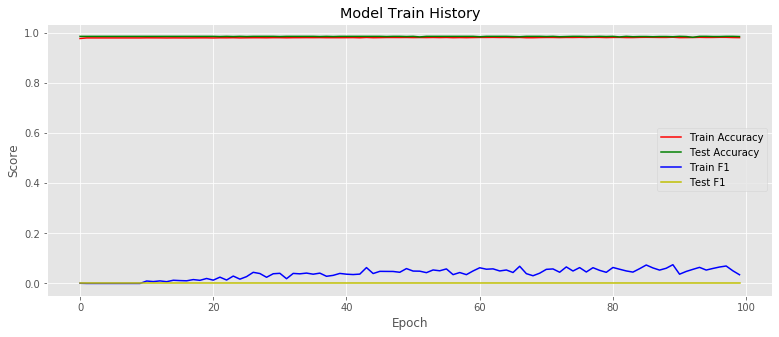

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,98.59,0.0,0.0,0.0,49.64,0.01,0.5,1329,18



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[1328    1]
 [  18    0]]

---> Training the `Wash Dryer 1` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.0888 - accuracy: 0.9701 - f1_macro: 0.0602 - val_loss: 0.0518 - val_accuracy: 0.9829 - val_f1_macro: 0.1705
Epoch 2/100
12123/12123 - 29s - loss: 0.0646 - accuracy: 0.9766 - f1_macro: 0.1814 - val_loss: 0.0442 - val_accuracy: 0.9829 - val_f1_macro: 0.1860
Epoch 3/100
12123/12123 - 29s - loss: 0.0589 - accuracy: 0.9800 - f1_macro: 0.3007 - val_loss: 0.0405 - val_accuracy: 0.9852 - val_f1_macro: 0.2326
Epoch 4/100
12123/12123 - 29s - loss: 0.0560 - accuracy: 0.9811 - f1_macro: 0.3048 - val_loss: 0.0373 - val_accuracy: 0.9859 - val_f1_macro: 0.3295
Epoch 5/100
12123/12123 - 29s - loss: 0.0559 - accuracy: 0.9818 - f1_macro: 0.3332 - val_loss: 0.0455 - val_accuracy: 0.9844 - val_f1_macro: 0.4101
Epoch 6/100
12123/12123 - 29s - loss: 0.0523 - accuracy: 0.9829 - f1_macro: 0.3595 - val_loss: 0.04

Epoch 55/100
12123/12123 - 29s - loss: 0.0352 - accuracy: 0.9885 - f1_macro: 0.4669 - val_loss: 0.0274 - val_accuracy: 0.9896 - val_f1_macro: 0.4535
Epoch 56/100
12123/12123 - 29s - loss: 0.0333 - accuracy: 0.9885 - f1_macro: 0.4709 - val_loss: 0.0300 - val_accuracy: 0.9889 - val_f1_macro: 0.3450
Epoch 57/100
12123/12123 - 29s - loss: 0.0350 - accuracy: 0.9868 - f1_macro: 0.4304 - val_loss: 0.0283 - val_accuracy: 0.9881 - val_f1_macro: 0.3450
Epoch 58/100
12123/12123 - 29s - loss: 0.0325 - accuracy: 0.9881 - f1_macro: 0.4440 - val_loss: 0.0285 - val_accuracy: 0.9881 - val_f1_macro: 0.3915
Epoch 59/100
12123/12123 - 29s - loss: 0.0344 - accuracy: 0.9880 - f1_macro: 0.4864 - val_loss: 0.0274 - val_accuracy: 0.9896 - val_f1_macro: 0.3992
Epoch 60/100
12123/12123 - 29s - loss: 0.0331 - accuracy: 0.9879 - f1_macro: 0.4689 - val_loss: 0.0292 - val_accuracy: 0.9903 - val_f1_macro: 0.4953
Epoch 61/100
12123/12123 - 29s - loss: 0.0315 - accuracy: 0.9889 - f1_macro: 0.4613 - val_loss: 0.0335 - v

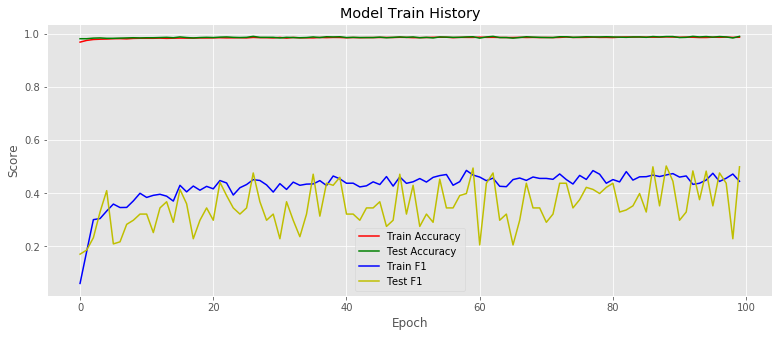

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,99.18,77.14,90.0,83.08,91.33,0.01,0.95,1317,30



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[1309    8]
 [   3   27]]

---> Training the `Microwave` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.0582 - accuracy: 0.9881 - f1_macro: 0.0000e+00 - val_loss: 0.0548 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0390 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0508 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0371 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0445 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0359 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0442 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0353 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0492 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0334 - accuracy: 

Epoch 54/100
12123/12123 - 29s - loss: 0.0241 - accuracy: 0.9933 - f1_macro: 0.0378 - val_loss: 0.0655 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 55/100
12123/12123 - 29s - loss: 0.0233 - accuracy: 0.9941 - f1_macro: 0.0558 - val_loss: 0.0518 - val_accuracy: 0.9903 - val_f1_macro: 0.0388
Epoch 56/100
12123/12123 - 29s - loss: 0.0241 - accuracy: 0.9941 - f1_macro: 0.0444 - val_loss: 0.0555 - val_accuracy: 0.9889 - val_f1_macro: 0.0155
Epoch 57/100
12123/12123 - 29s - loss: 0.0227 - accuracy: 0.9935 - f1_macro: 0.0347 - val_loss: 0.0588 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 58/100
12123/12123 - 29s - loss: 0.0232 - accuracy: 0.9936 - f1_macro: 0.0427 - val_loss: 0.0719 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 59/100
12123/12123 - 29s - loss: 0.0219 - accuracy: 0.9940 - f1_macro: 0.0519 - val_loss: 0.0732 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 60/100
12123/12123 - 29s - loss: 0.0239 - accuracy: 0.9938 - f1_macro: 0.0510 - val_loss: 0.0669 - v

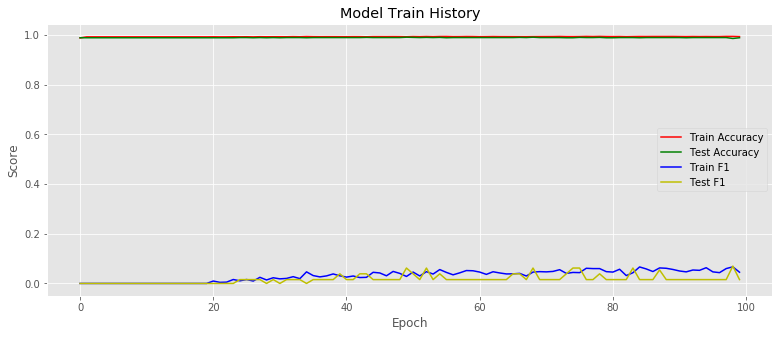

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,98.89,50.0,6.67,11.76,55.6,0.01,0.53,1332,15



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[1331    1]
 [  14    1]]



In [16]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = vgg_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_gaf_images, y_train[:, i],
        validation_data=(test_gaf_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_gaf_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

---> Training the `Refrigerator` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.6660 - accuracy: 0.6188 - f1_macro: 0.2662 - val_loss: 0.6574 - val_accuracy: 0.6444 - val_f1_macro: 0.4221
Epoch 2/100
12123/12123 - 9s - loss: 0.6567 - accuracy: 0.6356 - f1_macro: 0.3268 - val_loss: 0.6589 - val_accuracy: 0.6273 - val_f1_macro: 0.3325
Epoch 3/100
12123/12123 - 9s - loss: 0.6507 - accuracy: 0.6458 - f1_macro: 0.3567 - val_loss: 0.6550 - val_accuracy: 0.6273 - val_f1_macro: 0.3521
Epoch 4/100
12123/12123 - 9s - loss: 0.6459 - accuracy: 0.6510 - f1_macro: 0.3693 - val_loss: 0.6512 - val_accuracy: 0.6437 - val_f1_macro: 0.3751
Epoch 5/100
12123/12123 - 9s - loss: 0.6382 - accuracy: 0.6597 - f1_macro: 0.4015 - val_loss: 0.6463 - val_accuracy: 0.6518 - val_f1_macro: 0.4142
Epoch 6/100
12123/12123 - 9s - loss: 0.6361 - accuracy: 0.6601 - f1_macro: 0.4036 - val_loss: 0.6402 - val_accuracy: 0.6518 - val_f1_macro: 0.4225
Epoch 7/100
12123/12123 -

Epoch 56/100
12123/12123 - 9s - loss: 0.5457 - accuracy: 0.7245 - f1_macro: 0.5815 - val_loss: 0.6893 - val_accuracy: 0.6422 - val_f1_macro: 0.5106
Epoch 57/100
12123/12123 - 9s - loss: 0.5481 - accuracy: 0.7228 - f1_macro: 0.5782 - val_loss: 0.6676 - val_accuracy: 0.6503 - val_f1_macro: 0.4801
Epoch 58/100
12123/12123 - 9s - loss: 0.5427 - accuracy: 0.7270 - f1_macro: 0.5843 - val_loss: 0.6592 - val_accuracy: 0.6555 - val_f1_macro: 0.4936
Epoch 59/100
12123/12123 - 9s - loss: 0.5385 - accuracy: 0.7294 - f1_macro: 0.5864 - val_loss: 0.6781 - val_accuracy: 0.6526 - val_f1_macro: 0.4837
Epoch 60/100
12123/12123 - 9s - loss: 0.5424 - accuracy: 0.7270 - f1_macro: 0.5891 - val_loss: 0.6962 - val_accuracy: 0.6451 - val_f1_macro: 0.4741
Epoch 61/100
12123/12123 - 9s - loss: 0.5365 - accuracy: 0.7276 - f1_macro: 0.5877 - val_loss: 0.7031 - val_accuracy: 0.6399 - val_f1_macro: 0.4850
Epoch 62/100
12123/12123 - 9s - loss: 0.5345 - accuracy: 0.7355 - f1_macro: 0.5995 - val_loss: 0.7003 - val_accu

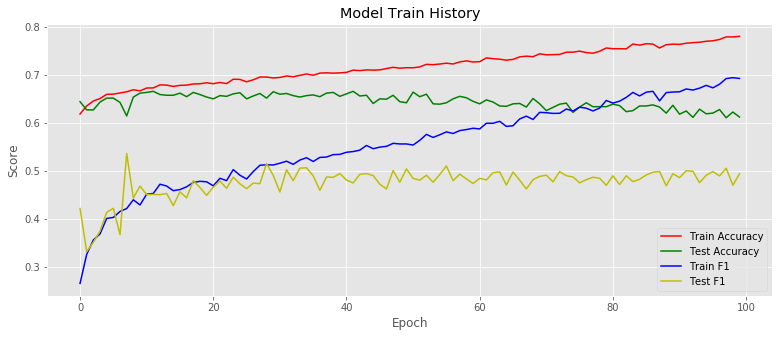

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,61.25,56.78,45.73,50.66,59.38,0.39,0.59,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[557 204]
 [318 268]]

---> Training the `Dishwasher` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 10s - loss: 0.0946 - accuracy: 0.9861 - f1_macro: 0.0000e+00 - val_loss: 0.0832 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0753 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0811 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0737 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0804 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0746 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0805 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0745 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0805 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0713 - accuracy: 0.9880 -

Epoch 53/100
12123/12123 - 9s - loss: 0.0663 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0811 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0659 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0816 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0674 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0808 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0650 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0819 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0666 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0807 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0659 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0663 - accuracy: 0.9880 

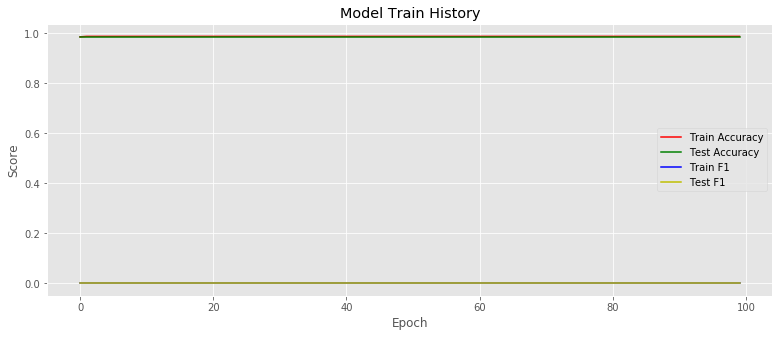

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.44,0.0,0.0,0.0,49.61,0.02,0.5,1326,21



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[1326    0]
 [  21    0]]

---> Training the `Furnace` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1264 - accuracy: 0.9792 - f1_macro: 0.0000e+00 - val_loss: 0.0702 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.1105 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0693 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.1024 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0688 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.1009 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0770 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.1010 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0689 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0989 - accuracy: 0.9805 - 

Epoch 53/100
12123/12123 - 9s - loss: 0.0982 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0721 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0984 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0722 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0985 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0717 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0973 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0725 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0980 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0733 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0983 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0725 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0987 - accuracy: 0.9805 

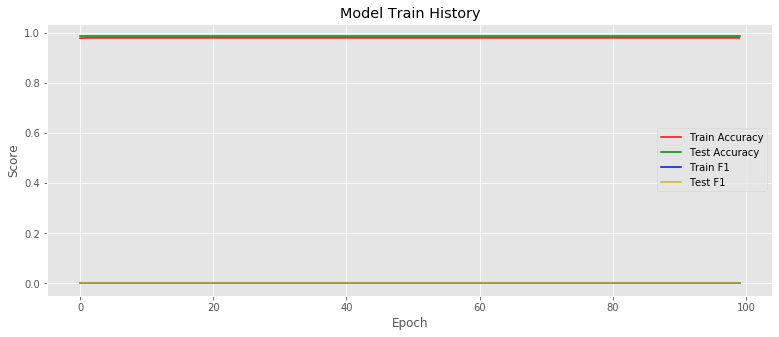

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,98.66,0.0,0.0,0.0,49.66,0.01,0.5,1329,18



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[1329    0]
 [  18    0]]

---> Training the `Wash Dryer 1` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1268 - accuracy: 0.9679 - f1_macro: 0.0000e+00 - val_loss: 0.1015 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0948 - accuracy: 0.9710 - f1_macro: 0.0000e+00 - val_loss: 0.0985 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0855 - accuracy: 0.9710 - f1_macro: 0.0018 - val_loss: 0.0587 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0755 - accuracy: 0.9711 - f1_macro: 0.0305 - val_loss: 0.0522 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0699 - accuracy: 0.9737 - f1_macro: 0.1157 - val_loss: 0.0654 - val_accuracy: 0.9733 - val_f1_macro: 0.2047
Epoch 6/100
12123/12123 - 9s - loss: 0.0674 - accuracy: 0.9767 - f1_macro: 0.24

Epoch 56/100
12123/12123 - 9s - loss: 0.0233 - accuracy: 0.9918 - f1_macro: 0.5128 - val_loss: 0.0380 - val_accuracy: 0.9874 - val_f1_macro: 0.2814
Epoch 57/100
12123/12123 - 9s - loss: 0.0218 - accuracy: 0.9907 - f1_macro: 0.4686 - val_loss: 0.0435 - val_accuracy: 0.9844 - val_f1_macro: 0.2814
Epoch 58/100
12123/12123 - 9s - loss: 0.0268 - accuracy: 0.9907 - f1_macro: 0.4469 - val_loss: 0.0440 - val_accuracy: 0.9874 - val_f1_macro: 0.2814
Epoch 59/100
12123/12123 - 9s - loss: 0.0199 - accuracy: 0.9915 - f1_macro: 0.5153 - val_loss: 0.0438 - val_accuracy: 0.9866 - val_f1_macro: 0.2814
Epoch 60/100
12123/12123 - 9s - loss: 0.0221 - accuracy: 0.9917 - f1_macro: 0.5062 - val_loss: 0.0484 - val_accuracy: 0.9859 - val_f1_macro: 0.3047
Epoch 61/100
12123/12123 - 9s - loss: 0.0523 - accuracy: 0.9815 - f1_macro: 0.3163 - val_loss: 0.0506 - val_accuracy: 0.9837 - val_f1_macro: 0.1550
Epoch 62/100
12123/12123 - 9s - loss: 0.0520 - accuracy: 0.9803 - f1_macro: 0.3241 - val_loss: 0.0538 - val_accu

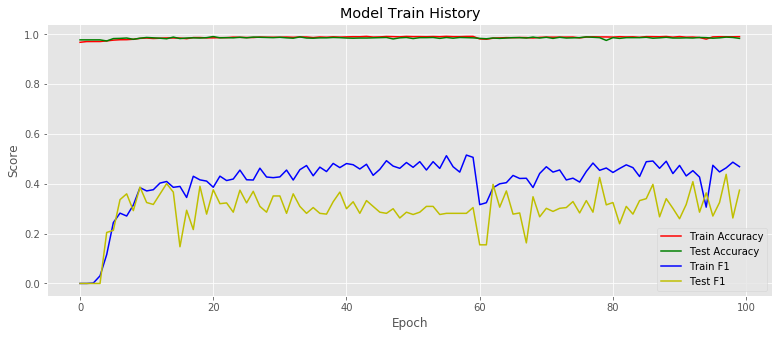

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.37,61.11,73.33,66.67,82.91,0.02,0.86,1317,30



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[1303   14]
 [   8   22]]

---> Training the `Microwave` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.0667 - accuracy: 0.9903 - f1_macro: 0.0000e+00 - val_loss: 0.0563 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0546 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0727 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0452 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0582 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0434 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0564 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0480 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0640 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0521 - accuracy: 0.992

Epoch 53/100
12123/12123 - 9s - loss: 0.0456 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0620 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0464 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0626 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0462 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0622 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0453 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0619 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0462 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0619 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0466 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0623 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0450 - accuracy: 0.9925 

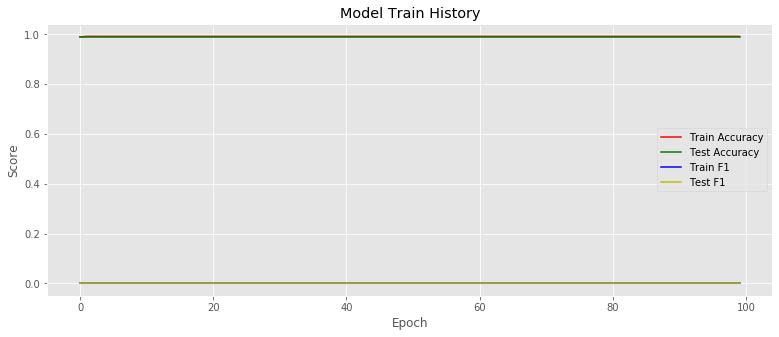

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,98.89,0.0,0.0,0.0,49.72,0.01,0.5,1332,15



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[1332    0]
 [  15    0]]



In [18]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_gaf_images, y_train[:, i],
        validation_data=(test_gaf_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_gaf_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [17]:
# i = 4
# model = vgg_model_appliance()

# # Calibrating model..
# callback = model.fit(
#     train_gaf_images, yb1_train[:, i],
#     validation_data=(test_gaf_images, yb1_test[:, i]), 
#     epochs=100, batch_size=32,
#     verbose = 2#, callbacks = [tqdm_callback]
# )

# # Plot metrics...
# fig = plt.figure(figsize=(13,5))
# line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
# line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
# line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
# line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
# plt.title("Model Train History")
# plt.xlabel("Epoch")
# plt.ylabel("Score")
# plt.legend()
# plt.show()

# # Final report (validated on test set)
# y_pred = np.array(model.predict(test_gaf_images).round())
# classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])

# print("")

### RP

---> Training the `Refrigerator` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.6600 - accuracy: 0.6248 - f1_macro: 0.2775 - val_loss: 0.6381 - val_accuracy: 0.6540 - val_f1_macro: 0.4371
Epoch 2/100
12123/12123 - 9s - loss: 0.6373 - accuracy: 0.6636 - f1_macro: 0.4213 - val_loss: 0.6301 - val_accuracy: 0.6659 - val_f1_macro: 0.4874
Epoch 3/100
12123/12123 - 9s - loss: 0.6226 - accuracy: 0.6706 - f1_macro: 0.4611 - val_loss: 0.6288 - val_accuracy: 0.6637 - val_f1_macro: 0.4279
Epoch 4/100
12123/12123 - 9s - loss: 0.6162 - accuracy: 0.6753 - f1_macro: 0.4615 - val_loss: 0.6320 - val_accuracy: 0.6518 - val_f1_macro: 0.4169
Epoch 5/100
12123/12123 - 9s - loss: 0.6089 - accuracy: 0.6786 - f1_macro: 0.4852 - val_loss: 0.6116 - val_accuracy: 0.6533 - val_f1_macro: 0.5767
Epoch 6/100
12123/12123 - 9s - loss: 0.6047 - accuracy: 0.6832 - f1_macro: 0.4997 - val_loss: 0.6329 - val_accuracy: 0.6392 - val_f1_macro: 0.6321
Epoch 7/100
12123/12123 -

Epoch 56/100
12123/12123 - 9s - loss: 0.4757 - accuracy: 0.7543 - f1_macro: 0.6629 - val_loss: 0.6138 - val_accuracy: 0.6659 - val_f1_macro: 0.5574
Epoch 57/100
12123/12123 - 9s - loss: 0.4665 - accuracy: 0.7553 - f1_macro: 0.6731 - val_loss: 0.6028 - val_accuracy: 0.6674 - val_f1_macro: 0.5793
Epoch 58/100
12123/12123 - 9s - loss: 0.4633 - accuracy: 0.7628 - f1_macro: 0.6770 - val_loss: 0.6589 - val_accuracy: 0.6451 - val_f1_macro: 0.5623
Epoch 59/100
12123/12123 - 9s - loss: 0.4637 - accuracy: 0.7633 - f1_macro: 0.6766 - val_loss: 0.6688 - val_accuracy: 0.6340 - val_f1_macro: 0.5816
Epoch 60/100
12123/12123 - 9s - loss: 0.4661 - accuracy: 0.7661 - f1_macro: 0.6838 - val_loss: 0.6509 - val_accuracy: 0.6689 - val_f1_macro: 0.5641
Epoch 61/100
12123/12123 - 9s - loss: 0.4587 - accuracy: 0.7689 - f1_macro: 0.6877 - val_loss: 0.6164 - val_accuracy: 0.6667 - val_f1_macro: 0.5951
Epoch 62/100
12123/12123 - 9s - loss: 0.4597 - accuracy: 0.7638 - f1_macro: 0.6834 - val_loss: 0.6357 - val_accu

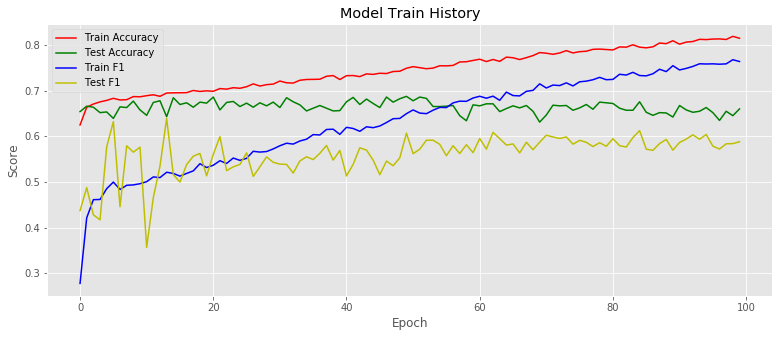

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,66.0,61.9,56.83,59.25,65.04,0.34,0.65,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[556 205]
 [253 333]]

---> Training the `Dishwasher` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 10s - loss: 0.1058 - accuracy: 0.9870 - f1_macro: 0.0000e+00 - val_loss: 0.0849 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0782 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0815 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0736 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0802 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0777 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0812 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0752 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0806 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0721 - accuracy: 0.9880 -

Epoch 53/100
12123/12123 - 9s - loss: 0.0656 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0810 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0662 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0820 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0665 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0807 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0659 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0820 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0668 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0805 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0663 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0809 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0662 - accuracy: 0.9880 

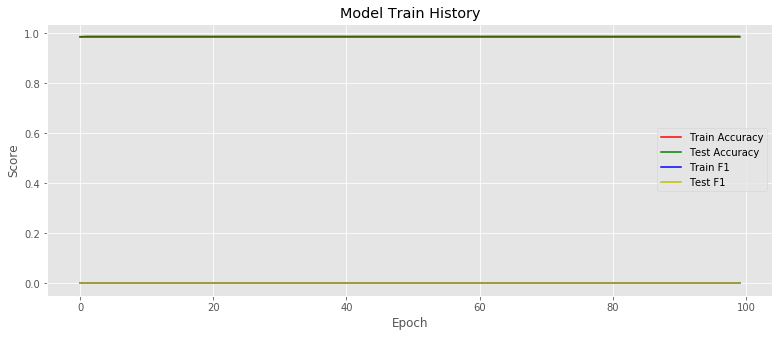

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.44,0.0,0.0,0.0,49.61,0.02,0.5,1326,21



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[1326    0]
 [  21    0]]

---> Training the `Furnace` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1219 - accuracy: 0.9788 - f1_macro: 2.3987e-04 - val_loss: 0.0691 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.1018 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0676 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0991 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0713 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.1056 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.1134 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.1014 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0696 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0992 - accuracy: 0.9805 - 

Epoch 54/100
12123/12123 - 9s - loss: 0.0751 - accuracy: 0.9810 - f1_macro: 0.0290 - val_loss: 0.0832 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 10s - loss: 0.0767 - accuracy: 0.9812 - f1_macro: 0.0355 - val_loss: 0.0707 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0741 - accuracy: 0.9819 - f1_macro: 0.0488 - val_loss: 0.0778 - val_accuracy: 0.9866 - val_f1_macro: 0.0233
Epoch 57/100
12123/12123 - 10s - loss: 0.0744 - accuracy: 0.9815 - f1_macro: 0.0389 - val_loss: 0.0728 - val_accuracy: 0.9866 - val_f1_macro: 0.0233
Epoch 58/100
12123/12123 - 10s - loss: 0.0743 - accuracy: 0.9818 - f1_macro: 0.0431 - val_loss: 0.0711 - val_accuracy: 0.9866 - val_f1_macro: 0.0233
Epoch 59/100
12123/12123 - 10s - loss: 0.0757 - accuracy: 0.9818 - f1_macro: 0.0384 - val_loss: 0.0784 - val_accuracy: 0.9866 - val_f1_macro: 0.0233
Epoch 60/100
12123/12123 - 9s - loss: 0.0709 - accuracy: 0.9819 - f1_macro: 0.0485 - val_loss: 0.080

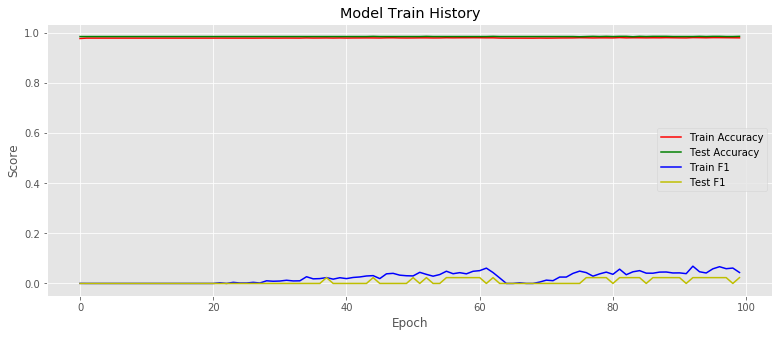

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,98.74,100.0,5.56,10.53,54.95,0.01,0.53,1329,18



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[1329    0]
 [  17    1]]

---> Training the `Wash Dryer 1` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1175 - accuracy: 0.9682 - f1_macro: 0.0000e+00 - val_loss: 0.0661 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.1003 - accuracy: 0.9710 - f1_macro: 0.0000e+00 - val_loss: 0.0857 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0916 - accuracy: 0.9706 - f1_macro: 0.0000e+00 - val_loss: 0.0681 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0814 - accuracy: 0.9712 - f1_macro: 0.0206 - val_loss: 0.0541 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0804 - accuracy: 0.9735 - f1_macro: 0.0717 - val_loss: 0.0654 - val_accuracy: 0.9777 - val_f1_macro: 0.1969
Epoch 6/100
12123/12123 - 9s - loss: 0.0726 - accuracy: 0.9748 - f1_macro: 

Epoch 56/100
12123/12123 - 9s - loss: 0.0315 - accuracy: 0.9886 - f1_macro: 0.4633 - val_loss: 0.0494 - val_accuracy: 0.9852 - val_f1_macro: 0.3256
Epoch 57/100
12123/12123 - 9s - loss: 0.0300 - accuracy: 0.9894 - f1_macro: 0.4675 - val_loss: 0.0564 - val_accuracy: 0.9807 - val_f1_macro: 0.3062
Epoch 58/100
12123/12123 - 9s - loss: 0.0361 - accuracy: 0.9883 - f1_macro: 0.4399 - val_loss: 0.0494 - val_accuracy: 0.9837 - val_f1_macro: 0.1744
Epoch 59/100
12123/12123 - 9s - loss: 0.0379 - accuracy: 0.9887 - f1_macro: 0.4761 - val_loss: 0.0494 - val_accuracy: 0.9859 - val_f1_macro: 0.2364
Epoch 60/100
12123/12123 - 9s - loss: 0.0366 - accuracy: 0.9906 - f1_macro: 0.4963 - val_loss: 0.0591 - val_accuracy: 0.9837 - val_f1_macro: 0.3798
Epoch 61/100
12123/12123 - 9s - loss: 0.0297 - accuracy: 0.9916 - f1_macro: 0.4793 - val_loss: 0.0545 - val_accuracy: 0.9829 - val_f1_macro: 0.4388
Epoch 62/100
12123/12123 - 9s - loss: 0.0301 - accuracy: 0.9903 - f1_macro: 0.4791 - val_loss: 0.0545 - val_accu

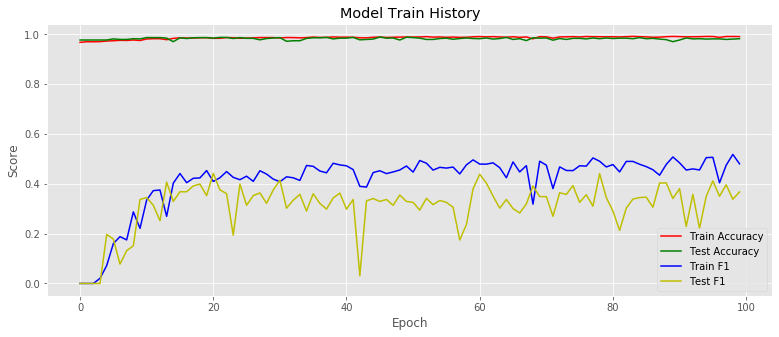

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.29,59.46,73.33,65.67,82.4,0.02,0.86,1317,30



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[1302   15]
 [   8   22]]

---> Training the `Microwave` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.0666 - accuracy: 0.9918 - f1_macro: 0.0000e+00 - val_loss: 0.0563 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0507 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0760 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0480 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0560 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0505 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0570 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0415 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0736 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 0.0396 - accuracy: 0.992

Epoch 55/100
12123/12123 - 9s - loss: 0.0236 - accuracy: 0.9944 - f1_macro: 0.0734 - val_loss: 0.0499 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0233 - accuracy: 0.9946 - f1_macro: 0.0685 - val_loss: 0.0543 - val_accuracy: 0.9889 - val_f1_macro: 0.0233
Epoch 57/100
12123/12123 - 9s - loss: 0.0240 - accuracy: 0.9951 - f1_macro: 0.0853 - val_loss: 0.0508 - val_accuracy: 0.9889 - val_f1_macro: 0.0233
Epoch 58/100
12123/12123 - 9s - loss: 0.0215 - accuracy: 0.9951 - f1_macro: 0.0879 - val_loss: 0.0578 - val_accuracy: 0.9881 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0215 - accuracy: 0.9949 - f1_macro: 0.0888 - val_loss: 0.0763 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 60/100
12123/12123 - 9s - loss: 0.0199 - accuracy: 0.9949 - f1_macro: 0.0928 - val_loss: 0.0695 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 61/100
12123/12123 - 9s - loss: 0.0193 - accuracy: 0.9958 - f1_macro: 0.1091 - val_loss: 0.060

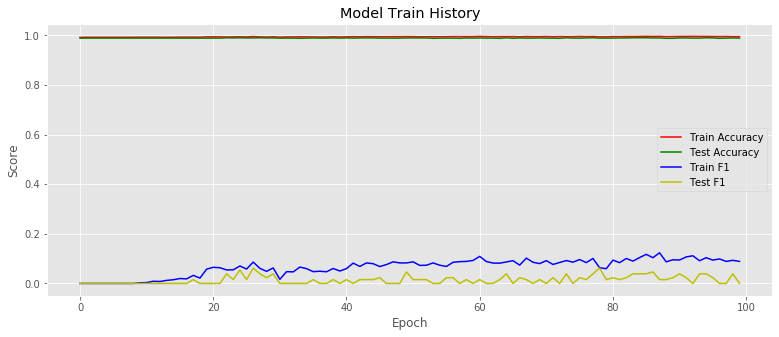

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,98.89,0.0,0.0,0.0,49.72,0.01,0.5,1332,15



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[1332    0]
 [  15    0]]



In [20]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, y_train[:, i],
        #train_rp_images[:3000,:,:,:], y_train[:3000, i],
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

Training the `Refrigerator` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.6466 - accuracy: 0.6494 - f1_macro: 0.4454 - val_loss: 0.6294 - val_accuracy: 0.6563 - val_f1_macro: 0.4443
Epoch 2/100
12123/12123 - 29s - loss: 0.6241 - accuracy: 0.6715 - f1_macro: 0.4606 - val_loss: 0.6161 - val_accuracy: 0.6667 - val_f1_macro: 0.4754
Epoch 3/100
12123/12123 - 29s - loss: 0.6138 - accuracy: 0.6800 - f1_macro: 0.4862 - val_loss: 0.6151 - val_accuracy: 0.6667 - val_f1_macro: 0.4546
Epoch 4/100
12123/12123 - 29s - loss: 0.6098 - accuracy: 0.6800 - f1_macro: 0.4869 - val_loss: 0.6208 - val_accuracy: 0.6674 - val_f1_macro: 0.4408
Epoch 5/100
12123/12123 - 29s - loss: 0.6059 - accuracy: 0.6831 - f1_macro: 0.4979 - val_loss: 0.6108 - val_accuracy: 0.6741 - val_f1_macro: 0.4777
Epoch 6/100
12123/12123 - 29s - loss: 0.6035 - accuracy: 0.6815 - f1_macro: 0.4951 - val_loss: 0.6045 - val_accuracy: 0.6733 - val_f1_macro: 0.4925
Epoch 7/100
12123/12123 -

Epoch 56/100
12123/12123 - 29s - loss: 0.5652 - accuracy: 0.7031 - f1_macro: 0.5309 - val_loss: 0.5985 - val_accuracy: 0.6696 - val_f1_macro: 0.5154
Epoch 57/100
12123/12123 - 29s - loss: 0.5641 - accuracy: 0.7050 - f1_macro: 0.5337 - val_loss: 0.5962 - val_accuracy: 0.6785 - val_f1_macro: 0.4848
Epoch 58/100
12123/12123 - 29s - loss: 0.5620 - accuracy: 0.7029 - f1_macro: 0.5294 - val_loss: 0.5909 - val_accuracy: 0.6815 - val_f1_macro: 0.5196
Epoch 59/100
12123/12123 - 29s - loss: 0.5618 - accuracy: 0.7035 - f1_macro: 0.5315 - val_loss: 0.5923 - val_accuracy: 0.6778 - val_f1_macro: 0.5203
Epoch 60/100
12123/12123 - 29s - loss: 0.5627 - accuracy: 0.7035 - f1_macro: 0.5309 - val_loss: 0.5915 - val_accuracy: 0.6733 - val_f1_macro: 0.5083
Epoch 61/100
12123/12123 - 29s - loss: 0.5604 - accuracy: 0.7035 - f1_macro: 0.5326 - val_loss: 0.5970 - val_accuracy: 0.6793 - val_f1_macro: 0.5084
Epoch 62/100
12123/12123 - 29s - loss: 0.5602 - accuracy: 0.7066 - f1_macro: 0.5391 - val_loss: 0.6010 - v

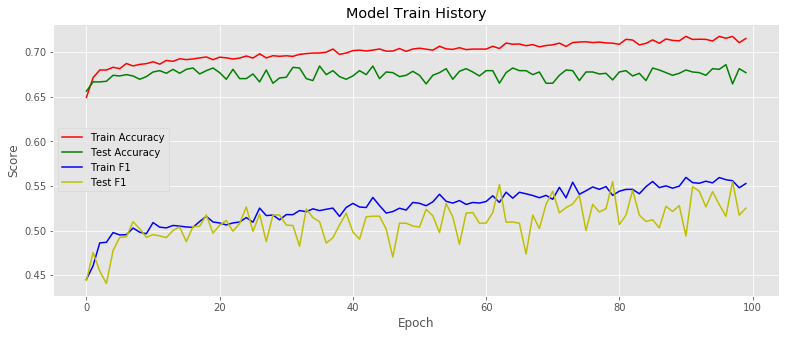

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,67.71,72.54,41.47,52.77,64.12,0.32,0.65,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[669  92]
 [343 243]]

Training the `Dishwasher` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.0848 - accuracy: 0.9845 - f1_macro: 4.3975e-04 - val_loss: 0.0982 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0747 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0761 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0694 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0761 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0691 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0758 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0677 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0771 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0662 - accuracy: 0.9880 -

Epoch 54/100
12123/12123 - 29s - loss: 0.0512 - accuracy: 0.9887 - f1_macro: 0.0242 - val_loss: 0.0952 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 29s - loss: 0.0512 - accuracy: 0.9888 - f1_macro: 0.0273 - val_loss: 0.0731 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 29s - loss: 0.0492 - accuracy: 0.9889 - f1_macro: 0.0339 - val_loss: 0.0762 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 29s - loss: 0.0499 - accuracy: 0.9885 - f1_macro: 0.0224 - val_loss: 0.0753 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 29s - loss: 0.0512 - accuracy: 0.9891 - f1_macro: 0.0342 - val_loss: 0.0761 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 29s - loss: 0.0482 - accuracy: 0.9888 - f1_macro: 0.0193 - val_loss: 0.0921 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 60/100
12123/12123 - 29s - loss: 0.0506 - accuracy: 0.9889 - f1_macro: 0.029

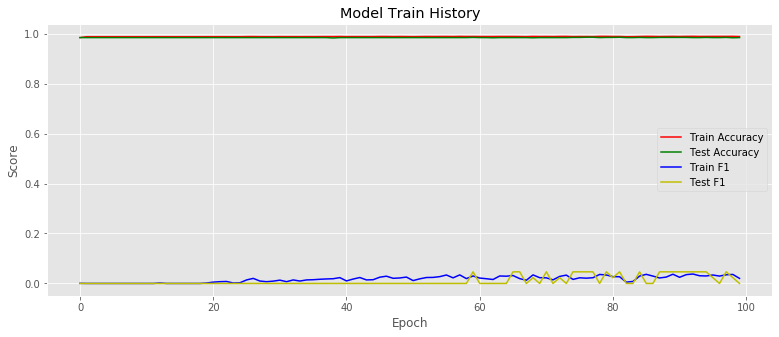

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.44,0.0,0.0,0.0,49.61,0.02,0.5,1326,21



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[1326    0]
 [  21    0]]

Training the `Furnace` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 31s - loss: 0.1092 - accuracy: 0.9774 - f1_macro: 3.2982e-04 - val_loss: 0.0665 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0927 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0680 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0912 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0640 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0932 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0724 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0890 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0629 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0868 - accuracy: 0.9805 - 

Epoch 54/100
12123/12123 - 29s - loss: 0.0706 - accuracy: 0.9823 - f1_macro: 0.0550 - val_loss: 0.0618 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 29s - loss: 0.0690 - accuracy: 0.9820 - f1_macro: 0.0500 - val_loss: 0.0631 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 29s - loss: 0.0724 - accuracy: 0.9821 - f1_macro: 0.0536 - val_loss: 0.0618 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 29s - loss: 0.0723 - accuracy: 0.9815 - f1_macro: 0.0431 - val_loss: 0.0619 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 29s - loss: 0.0707 - accuracy: 0.9817 - f1_macro: 0.0361 - val_loss: 0.0608 - val_accuracy: 0.9874 - val_f1_macro: 0.0233
Epoch 59/100
12123/12123 - 29s - loss: 0.0699 - accuracy: 0.9825 - f1_macro: 0.0547 - val_loss: 0.0600 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 60/100
12123/12123 - 29s - loss: 0.0687 - accuracy: 0.9823 - f1_macro: 0.0567 - 

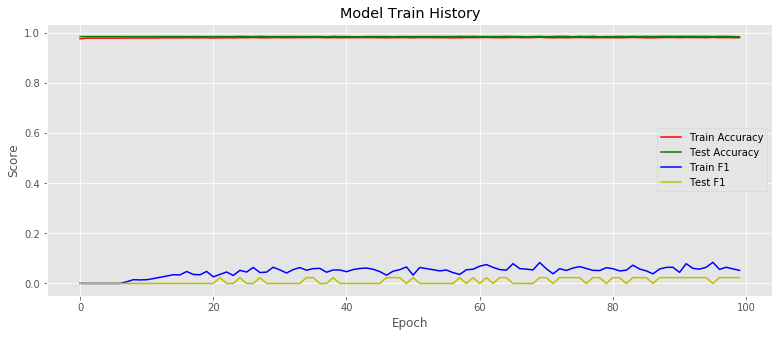

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,98.59,33.33,5.56,9.52,54.41,0.01,0.53,1329,18



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[1327    2]
 [  17    1]]

Training the `Wash Dryer 1` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 30s - loss: 0.0905 - accuracy: 0.9691 - f1_macro: 0.0533 - val_loss: 0.0562 - val_accuracy: 0.9800 - val_f1_macro: 0.1008
Epoch 2/100
12123/12123 - 29s - loss: 0.0685 - accuracy: 0.9755 - f1_macro: 0.1721 - val_loss: 0.0507 - val_accuracy: 0.9822 - val_f1_macro: 0.1628
Epoch 3/100
12123/12123 - 29s - loss: 0.0630 - accuracy: 0.9792 - f1_macro: 0.2748 - val_loss: 0.0482 - val_accuracy: 0.9807 - val_f1_macro: 0.1163
Epoch 4/100
12123/12123 - 29s - loss: 0.0593 - accuracy: 0.9795 - f1_macro: 0.2514 - val_loss: 0.0444 - val_accuracy: 0.9844 - val_f1_macro: 0.2403
Epoch 5/100
12123/12123 - 29s - loss: 0.0576 - accuracy: 0.9810 - f1_macro: 0.3156 - val_loss: 0.0505 - val_accuracy: 0.9814 - val_f1_macro: 0.3643
Epoch 6/100
12123/12123 - 29s - loss: 0.0550 - accuracy: 0.9828 - f1_macro: 0.3538 - val_loss: 0.0448 - 

Epoch 55/100
12123/12123 - 29s - loss: 0.0352 - accuracy: 0.9877 - f1_macro: 0.4371 - val_loss: 0.0427 - val_accuracy: 0.9866 - val_f1_macro: 0.3899
Epoch 56/100
12123/12123 - 29s - loss: 0.0346 - accuracy: 0.9874 - f1_macro: 0.4386 - val_loss: 0.0403 - val_accuracy: 0.9859 - val_f1_macro: 0.2984
Epoch 57/100
12123/12123 - 29s - loss: 0.0346 - accuracy: 0.9878 - f1_macro: 0.4453 - val_loss: 0.0422 - val_accuracy: 0.9896 - val_f1_macro: 0.3295
Epoch 58/100
12123/12123 - 29s - loss: 0.0364 - accuracy: 0.9869 - f1_macro: 0.4412 - val_loss: 0.0396 - val_accuracy: 0.9866 - val_f1_macro: 0.3791
Epoch 59/100
12123/12123 - 29s - loss: 0.0354 - accuracy: 0.9877 - f1_macro: 0.4595 - val_loss: 0.0432 - val_accuracy: 0.9859 - val_f1_macro: 0.3171
Epoch 60/100
12123/12123 - 29s - loss: 0.0342 - accuracy: 0.9881 - f1_macro: 0.4870 - val_loss: 0.0422 - val_accuracy: 0.9859 - val_f1_macro: 0.3860
Epoch 61/100
12123/12123 - 29s - loss: 0.0331 - accuracy: 0.9877 - f1_macro: 0.4569 - val_loss: 0.0413 - v

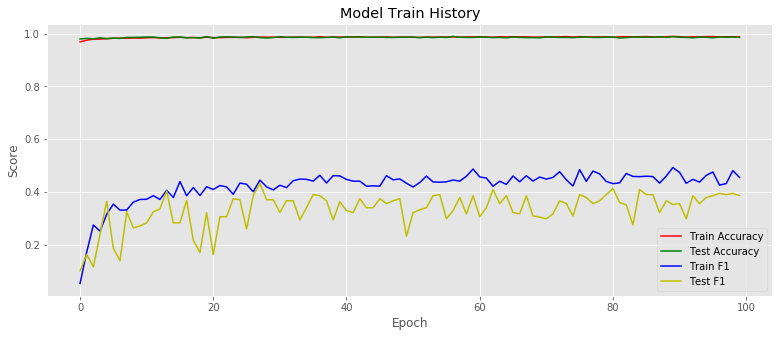

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.59,65.71,76.67,70.77,85.02,0.01,0.88,1317,30



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[1305   12]
 [   7   23]]

Training the `Microwave` model...

Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 31s - loss: 0.0576 - accuracy: 0.9864 - f1_macro: 0.0000e+00 - val_loss: 0.0552 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 29s - loss: 0.0380 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0516 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 29s - loss: 0.0397 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0425 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 29s - loss: 0.0369 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0418 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 29s - loss: 0.0351 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0450 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 29s - loss: 0.0343 - accuracy: 0.992

Epoch 54/100
12123/12123 - 29s - loss: 0.0241 - accuracy: 0.9924 - f1_macro: 0.0185 - val_loss: 0.0467 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 55/100
12123/12123 - 29s - loss: 0.0251 - accuracy: 0.9927 - f1_macro: 0.0106 - val_loss: 0.0426 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 56/100
12123/12123 - 29s - loss: 0.0238 - accuracy: 0.9931 - f1_macro: 0.0189 - val_loss: 0.0491 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 57/100
12123/12123 - 29s - loss: 0.0229 - accuracy: 0.9927 - f1_macro: 0.0123 - val_loss: 0.0468 - val_accuracy: 0.9896 - val_f1_macro: 0.0155
Epoch 58/100
12123/12123 - 29s - loss: 0.0246 - accuracy: 0.9927 - f1_macro: 0.0255 - val_loss: 0.0501 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 29s - loss: 0.0228 - accuracy: 0.9934 - f1_macro: 0.0334 - val_loss: 0.0659 - val_accuracy: 0.9881 - val_f1_macro: 0.0000e+00
Epoch 60/100
12123/12123 - 29s - loss: 0.0251 - accuracy: 0.9929 - f1_macro: 0.0176 - val_loss: 0.

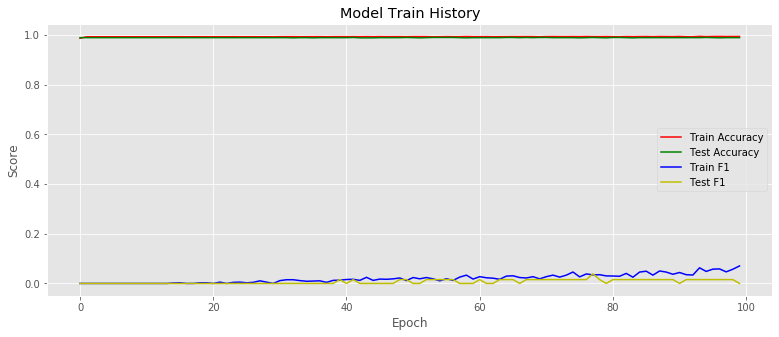

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,98.89,0.0,0.0,0.0,49.72,0.01,0.5,1332,15



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[1332    0]
 [  15    0]]



In [19]:
# Model fit...
for i in range(y_train.shape[1]):
    print("Training the `{}` model...\n".format(valid_appliances[i]))
    
    #model = cnn_model(output_layer_length=1)
    model = vgg_model_appliance()
    #image = preprocess_input(image)
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, y_train[:, i],
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    #classification_report(y_test[:, i], y_pred, labels = valid_appliances)
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Desblanceamento de Classes

---> Training the `Refrigerator` model...

Class weights: [0.85893439 1.19650612]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.6612 - accuracy: 0.6236 - f1_macro: 0.2899 - val_loss: 0.6441 - val_accuracy: 0.6578 - val_f1_macro: 0.4238
Epoch 2/100
12123/12123 - 9s - loss: 0.6348 - accuracy: 0.6676 - f1_macro: 0.4503 - val_loss: 0.6350 - val_accuracy: 0.6637 - val_f1_macro: 0.4485
Epoch 3/100
12123/12123 - 9s - loss: 0.6257 - accuracy: 0.6692 - f1_macro: 0.4495 - val_loss: 0.6271 - val_accuracy: 0.6592 - val_f1_macro: 0.4166
Epoch 4/100
12123/12123 - 9s - loss: 0.6173 - accuracy: 0.6703 - f1_macro: 0.4511 - val_loss: 0.6241 - val_accuracy: 0.6578 - val_f1_macro: 0.3977
Epoch 5/100
12123/12123 - 9s - loss: 0.6146 - accuracy: 0.6690 - f1_macro: 0.4519 - val_loss: 0.6097 - val_accuracy: 0.6674 - val_f1_macro: 0.4712
Epoch 6/100
12123/12123 - 9s - loss: 0.6061 - accuracy: 0.6769 - f1_macro: 0.4672 - val_loss: 0.6088 - val_accuracy: 0.6696 - val_f1_

Epoch 56/100
12123/12123 - 9s - loss: 0.5011 - accuracy: 0.7526 - f1_macro: 0.6756 - val_loss: 0.6344 - val_accuracy: 0.6548 - val_f1_macro: 0.5725
Epoch 57/100
12123/12123 - 9s - loss: 0.4944 - accuracy: 0.7572 - f1_macro: 0.6843 - val_loss: 0.6482 - val_accuracy: 0.6518 - val_f1_macro: 0.5487
Epoch 58/100
12123/12123 - 9s - loss: 0.4993 - accuracy: 0.7497 - f1_macro: 0.6760 - val_loss: 0.5998 - val_accuracy: 0.6667 - val_f1_macro: 0.5710
Epoch 59/100
12123/12123 - 9s - loss: 0.4910 - accuracy: 0.7583 - f1_macro: 0.6808 - val_loss: 0.6208 - val_accuracy: 0.6518 - val_f1_macro: 0.5803
Epoch 60/100
12123/12123 - 9s - loss: 0.4921 - accuracy: 0.7596 - f1_macro: 0.6832 - val_loss: 0.6145 - val_accuracy: 0.6615 - val_f1_macro: 0.5554
Epoch 61/100
12123/12123 - 9s - loss: 0.4842 - accuracy: 0.7647 - f1_macro: 0.6905 - val_loss: 0.6377 - val_accuracy: 0.6474 - val_f1_macro: 0.5869
Epoch 62/100
12123/12123 - 9s - loss: 0.4806 - accuracy: 0.7700 - f1_macro: 0.6989 - val_loss: 0.6382 - val_accu

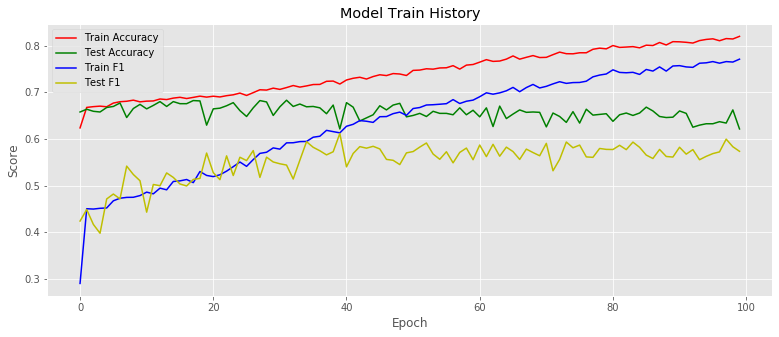

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,62.14,56.11,59.56,57.78,61.73,0.38,0.62,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[488 273]
 [237 349]]

---> Training the `Dishwasher` model...

Class weights: [ 0.50605276 41.80344828]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.0944 - accuracy: 0.9846 - f1_macro: 0.0000e+00 - val_loss: 0.0865 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0772 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0820 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0746 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0802 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0754 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0808 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0744 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0806 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123

Epoch 53/100
12123/12123 - 9s - loss: 0.0658 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0811 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0659 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0818 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0663 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0808 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0662 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0816 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0666 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0806 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0664 - accuracy: 0.9880 - f1_macro: 0.0000e+00 - val_loss: 0.0809 - val_accuracy: 0.9844 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0663 - accuracy: 0.9880 

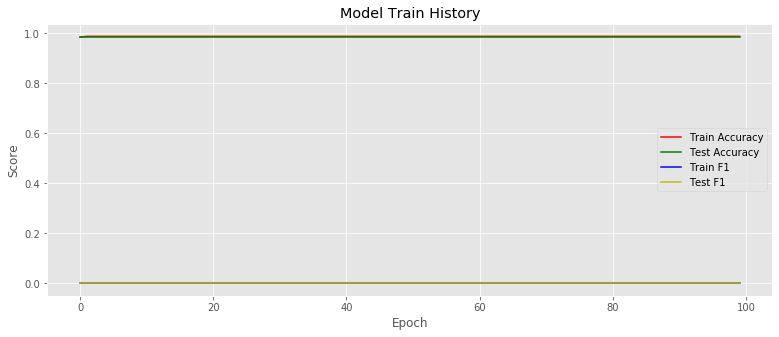

CLASSIFIER PERFORMANCE DISHWASHER MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Dishwasher,98.44,0.0,0.0,0.0,49.61,0.02,0.5,1326,21



CONFUSION MATRIX (OFF/ON):

 - Dishwasher:
[[1326    0]
 [  21    0]]

---> Training the `Furnace` model...

Class weights: [ 0.50996971 25.57594937]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1213 - accuracy: 0.9795 - f1_macro: 0.0000e+00 - val_loss: 0.0689 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.1034 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0695 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.1055 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0690 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.1052 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0852 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.1008 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0689 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 

Epoch 53/100
12123/12123 - 9s - loss: 0.0756 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0660 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 54/100
12123/12123 - 9s - loss: 0.0780 - accuracy: 0.9804 - f1_macro: 0.0018 - val_loss: 0.0816 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0758 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0676 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 56/100
12123/12123 - 9s - loss: 0.0783 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0674 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 57/100
12123/12123 - 9s - loss: 0.0771 - accuracy: 0.9805 - f1_macro: 0.0000e+00 - val_loss: 0.0754 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 58/100
12123/12123 - 9s - loss: 0.0753 - accuracy: 0.9803 - f1_macro: 0.0000e+00 - val_loss: 0.0688 - val_accuracy: 0.9866 - val_f1_macro: 0.0000e+00
Epoch 59/100
12123/12123 - 9s - loss: 0.0779 - accuracy: 0.9805 - f1

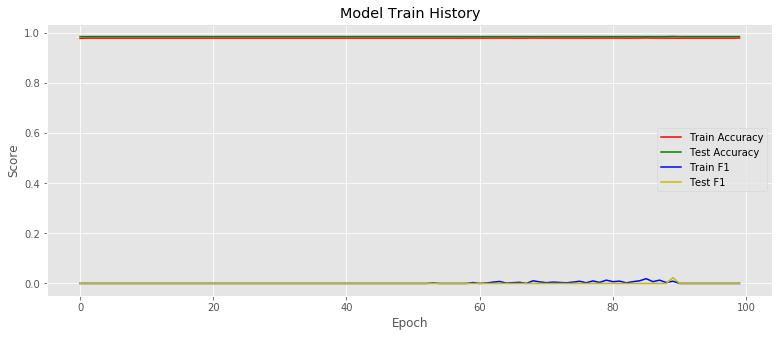

CLASSIFIER PERFORMANCE FURNACE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Furnace,98.66,0.0,0.0,0.0,49.66,0.01,0.5,1329,18



CONFUSION MATRIX (OFF/ON):

 - Furnace:
[[1329    0]
 [  18    0]]

---> Training the `Wash Dryer 1` model...

Class weights: [ 0.514952   17.22017045]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.1098 - accuracy: 0.9692 - f1_macro: 0.0000e+00 - val_loss: 0.0633 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0897 - accuracy: 0.9710 - f1_macro: 0.0000e+00 - val_loss: 0.0929 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0859 - accuracy: 0.9710 - f1_macro: 0.0026 - val_loss: 0.0648 - val_accuracy: 0.9777 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0736 - accuracy: 0.9743 - f1_macro: 0.1104 - val_loss: 0.0579 - val_accuracy: 0.9814 - val_f1_macro: 0.1395
Epoch 5/100
12123/12123 - 9s - loss: 0.0674 - accuracy: 0.9775 - f1_macro: 0.2661 - val_loss: 0.1013 - val_accuracy: 0.9384 - val_f1_macro: 0.3237
Epoch 6/100
12123/12123 - 9s - loss: 0.061

Epoch 55/100
12123/12123 - 9s - loss: 0.0202 - accuracy: 0.9912 - f1_macro: 0.4879 - val_loss: 0.0990 - val_accuracy: 0.9852 - val_f1_macro: 0.3829
Epoch 56/100
12123/12123 - 9s - loss: 0.0206 - accuracy: 0.9918 - f1_macro: 0.5192 - val_loss: 0.1092 - val_accuracy: 0.9748 - val_f1_macro: 0.3876
Epoch 57/100
12123/12123 - 9s - loss: 0.0257 - accuracy: 0.9903 - f1_macro: 0.4830 - val_loss: 0.0705 - val_accuracy: 0.9852 - val_f1_macro: 0.3736
Epoch 58/100
12123/12123 - 9s - loss: 0.0213 - accuracy: 0.9920 - f1_macro: 0.4894 - val_loss: 0.0929 - val_accuracy: 0.9837 - val_f1_macro: 0.3690
Epoch 59/100
12123/12123 - 9s - loss: 0.0239 - accuracy: 0.9907 - f1_macro: 0.5019 - val_loss: 0.1008 - val_accuracy: 0.9770 - val_f1_macro: 0.3504
Epoch 60/100
12123/12123 - 9s - loss: 0.0277 - accuracy: 0.9894 - f1_macro: 0.4931 - val_loss: 0.1089 - val_accuracy: 0.9733 - val_f1_macro: 0.3837
Epoch 61/100
12123/12123 - 9s - loss: 0.0262 - accuracy: 0.9900 - f1_macro: 0.4695 - val_loss: 0.0933 - val_accu

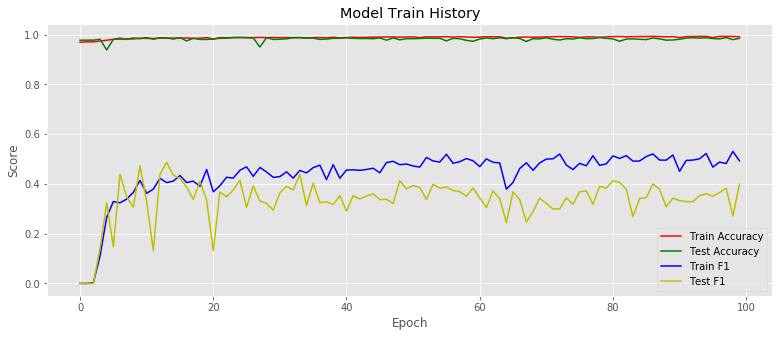

CLASSIFIER PERFORMANCE WASH DRYER 1 MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Wash Dryer 1,98.52,63.89,76.67,69.7,84.47,0.01,0.88,1317,30



CONFUSION MATRIX (OFF/ON):

 - Wash Dryer 1:
[[1304   13]
 [   7   23]]

---> Training the `Microwave` model...

Class weights: [ 0.50378158 66.60989011]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: 0.0665 - accuracy: 0.9917 - f1_macro: 0.0000e+00 - val_loss: 0.0544 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 0.0496 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0841 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 3/100
12123/12123 - 9s - loss: 0.0520 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0579 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 4/100
12123/12123 - 9s - loss: 0.0446 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0565 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 0.0432 - accuracy: 0.9925 - f1_macro: 0.0000e+00 - val_loss: 0.0638 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12

Epoch 54/100
12123/12123 - 9s - loss: 0.0257 - accuracy: 0.9941 - f1_macro: 0.0607 - val_loss: 0.0530 - val_accuracy: 0.9889 - val_f1_macro: 0.0000e+00
Epoch 55/100
12123/12123 - 9s - loss: 0.0258 - accuracy: 0.9941 - f1_macro: 0.0734 - val_loss: 0.0412 - val_accuracy: 0.9896 - val_f1_macro: 0.0233
Epoch 56/100
12123/12123 - 9s - loss: 0.0257 - accuracy: 0.9937 - f1_macro: 0.0500 - val_loss: 0.0523 - val_accuracy: 0.9896 - val_f1_macro: 0.0233
Epoch 57/100
12123/12123 - 9s - loss: 0.0272 - accuracy: 0.9946 - f1_macro: 0.0800 - val_loss: 0.0445 - val_accuracy: 0.9889 - val_f1_macro: 0.0388
Epoch 58/100
12123/12123 - 9s - loss: 0.0261 - accuracy: 0.9941 - f1_macro: 0.0734 - val_loss: 0.0552 - val_accuracy: 0.9896 - val_f1_macro: 0.0620
Epoch 59/100
12123/12123 - 9s - loss: 0.0229 - accuracy: 0.9943 - f1_macro: 0.0704 - val_loss: 0.0599 - val_accuracy: 0.9896 - val_f1_macro: 0.0233
Epoch 60/100
12123/12123 - 9s - loss: 0.0251 - accuracy: 0.9943 - f1_macro: 0.0770 - val_loss: 0.0507 - val_

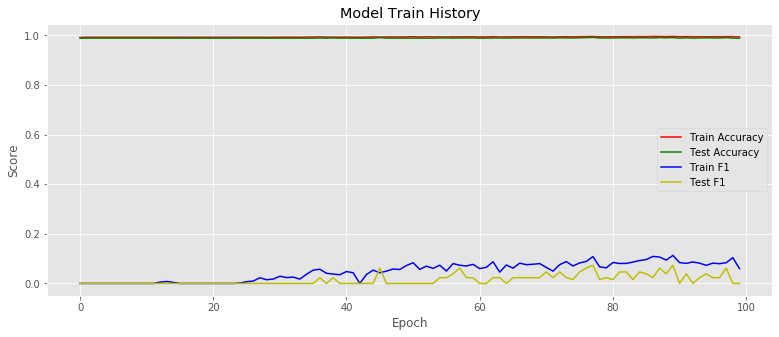

CLASSIFIER PERFORMANCE MICROWAVE MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Microwave,98.89,0.0,0.0,0.0,49.72,0.01,0.5,1332,15



CONFUSION MATRIX (OFF/ON):

 - Microwave:
[[1332    0]
 [  15    0]]



In [21]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train[:, i]),
        y_train[:, i]
    )
    print("Class weights:", class_weights)

    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, y_train[:, i],
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2,#, callbacks = [tqdm_callback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")


#### Focal Loss

---> Training the `Refrigerator` model...

Class weights: [0.85893439 1.19650612]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 12s - loss: 2.1835 - accuracy: 0.5824 - f1_macro: 0.0068 - val_loss: 2.2159 - val_accuracy: 0.5650 - val_f1_macro: 0.0000e+00
Epoch 2/100
12123/12123 - 9s - loss: 2.0843 - accuracy: 0.6146 - f1_macro: 0.1707 - val_loss: 2.0462 - val_accuracy: 0.6310 - val_f1_macro: 0.3193
Epoch 3/100
12123/12123 - 9s - loss: 2.0354 - accuracy: 0.6309 - f1_macro: 0.2407 - val_loss: 2.0376 - val_accuracy: 0.6310 - val_f1_macro: 0.3221
Epoch 4/100
12123/12123 - 9s - loss: 2.0220 - accuracy: 0.6312 - f1_macro: 0.2359 - val_loss: 2.0402 - val_accuracy: 0.5650 - val_f1_macro: 0.0000e+00
Epoch 5/100
12123/12123 - 9s - loss: 2.0170 - accuracy: 0.6258 - f1_macro: 0.2175 - val_loss: 2.0256 - val_accuracy: 0.5650 - val_f1_macro: 0.0000e+00
Epoch 6/100
12123/12123 - 9s - loss: 1.9959 - accuracy: 0.6320 - f1_macro: 0.2396 - val_loss: 2.0061 - val_accuracy: 0.59

Epoch 56/100
12123/12123 - 9s - loss: 1.6446 - accuracy: 0.6959 - f1_macro: 0.4383 - val_loss: 2.0006 - val_accuracy: 0.6563 - val_f1_macro: 0.3779
Epoch 57/100
12123/12123 - 9s - loss: 1.6695 - accuracy: 0.6848 - f1_macro: 0.4099 - val_loss: 2.1009 - val_accuracy: 0.6540 - val_f1_macro: 0.3700
Epoch 58/100
12123/12123 - 9s - loss: 1.6569 - accuracy: 0.6889 - f1_macro: 0.4207 - val_loss: 2.0863 - val_accuracy: 0.6540 - val_f1_macro: 0.3679
Epoch 59/100
12123/12123 - 9s - loss: 1.6547 - accuracy: 0.6903 - f1_macro: 0.4240 - val_loss: 2.1532 - val_accuracy: 0.6630 - val_f1_macro: 0.4225
Epoch 60/100
12123/12123 - 9s - loss: 1.6331 - accuracy: 0.6950 - f1_macro: 0.4397 - val_loss: 2.1403 - val_accuracy: 0.6555 - val_f1_macro: 0.3859
Epoch 61/100
12123/12123 - 9s - loss: 1.6198 - accuracy: 0.6987 - f1_macro: 0.4451 - val_loss: 2.1323 - val_accuracy: 0.6667 - val_f1_macro: 0.4204
Epoch 62/100
12123/12123 - 9s - loss: 1.6273 - accuracy: 0.6950 - f1_macro: 0.4394 - val_loss: 2.1928 - val_accu

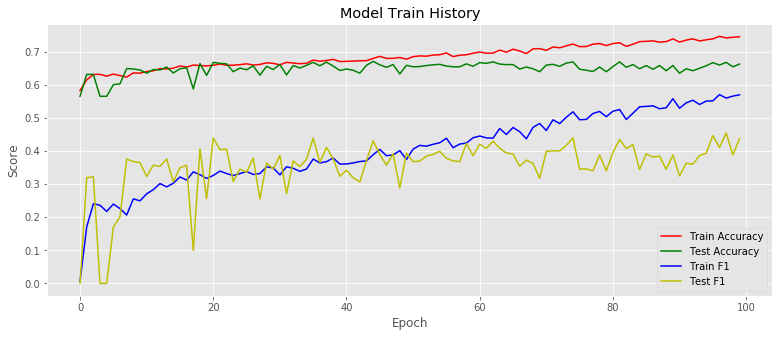

CLASSIFIER PERFORMANCE REFRIGERATOR MODEL:


,Appliance,Accuracy,Precision,Recall,F1-score,F1-macro,Hamming Loss,AUC,Support (y=0),Support (y=1)
0,Refrigerator,66.22,76.73,32.08,45.25,60.41,0.34,0.62,761,586



CONFUSION MATRIX (OFF/ON):

 - Refrigerator:
[[704  57]
 [398 188]]

---> Training the `Dishwasher` model...

Class weights: [ 0.50605276 41.80344828]
Train on 12123 samples, validate on 1347 samples
Epoch 1/100
12123/12123 - 11s - loss: nan - accuracy: 0.6318 - f1_macro: 0.0077 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 2/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 3/100
12123/12123 - 9s - loss: nan - accuracy: 0.0120 - f1_macro: 0.0234 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 4/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0236 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 5/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 6/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: na

Epoch 58/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0234 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 59/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 60/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 61/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 62/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0234 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 63/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 64/100
12123/12123 - 9s - loss: nan - accuracy: 0.0122 - f1_macro: 0.0235 - val_loss: nan - val_accuracy: 0.0178 - val_f1_macro: 0.0759
Epoch 

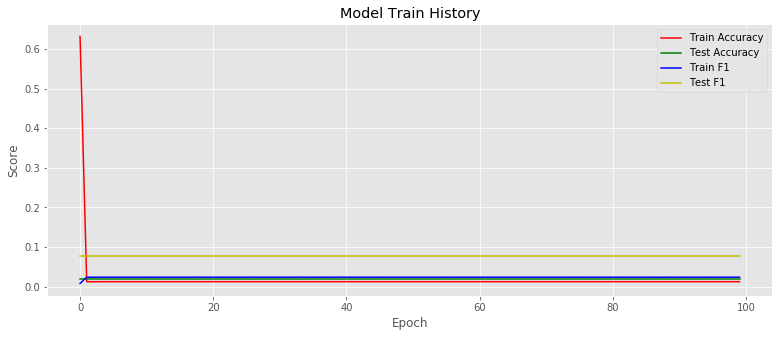

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [24]:
# CLASS WEIGHT
from sklearn.utils import class_weight

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    
    class_weights = class_weight.compute_class_weight(
        'balanced',
        np.unique(y_train[:, i]),
        y_train[:, i]
    )
    print("Class weights:", class_weights)

    model = cnn_model_appliance(loss_function = focal_loss)
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, y_train[:, i],
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2,#, callbacks = [tqdm_callback],
        class_weight = class_weights
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

#### Training Set Oversampling

In [ ]:
print("Original shape:", train_rp_images.shape)
print("Reshaped:", train_rp_images.reshape(train_rp_images.shape[0], -1).shape)
print("Reshaped to original:", train_rp_images.reshape(train_rp_images.shape[0], -1).reshape(train_rp_images.shape).shape)


In [ ]:
from collections import Counter
print("Original distribution (training set):", Counter(yb1_train[:, 1]))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
X_resampled, y_resampled = RandomOverSampler().fit_resample(
    train_rp_images.reshape(train_rp_images.shape[0], -1),
    y_train[:, 1]
)

print("New distribution (training set):", Counter(y_resampled))

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = SMOTE().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = ADASYN().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_resampled, y_resampled,
        validation_data=(test_rp_images, y_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    del X_resampled
    del y_resampled
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(y_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
# UNDERSAMPLING NO TESTE (???)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Model fit...
for i in range(y_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Resampling...
    X_train_resampled, y_train_resampled = RandomOverSampler().fit_resample(
        train_rp_images.reshape(train_rp_images.shape[0], -1),
        y_train[:, i]
    )
    X_train_resampled = X_train_resampled.reshape(
                    tuple(list([-1]) + list(train_rp_images.shape[1:]))
                )
    X_test_resampled, y_test_resampled = RandomUnderSampler().fit_resample(
        test_rp_images.reshape(test_rp_images.shape[0], -1),
        y_test[:, i]
    )
    X_test_resampled = X_test_resampled.reshape(
                    tuple(list([-1]) + list(test_rp_images.shape[1:]))
                )
    
    # Calibrating model..
    callback = model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_test_resampled, y_test_resampled), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["accuracy"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_accuracy"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_macro"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_macro"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(X_test_resampled).round())
    classification_report_appliance(y_test_resampled, y_pred, label = valid_appliances[i])
    
    print("")
    
    del X_train_resampled
    del y_train_resampled
    del X_test_resampled
    del y_test_resampled

# Análise Adicional dos Dados

In [60]:
yb1_train.shape

(4000, 5)

In [66]:
for i, appliance in enumerate(valid_appliances):
    y_i = yb1_train[:, i]
    supp_0 = y_i[y_i==0].shape[0]
    supp_1 = y_i[y_i==1].shape[0]
    print(appliance, 
          "-> Suport OFF (y=0):", supp_0, "({}%)".format( round((supp_0/yb1_train.shape[0])*100,2) ),
          "/ Support ON (y=1):", supp_1, "({}%)".format( round((supp_1/yb1_train.shape[0])*100,2) ),
          "\n"
         )


Refrigerator -> Suport OFF (y=0): 2393 (59.82%) / Support ON (y=1): 1607 (40.17%) 

Dishwasher -> Suport OFF (y=0): 3933 (98.32%) / Support ON (y=1): 67 (1.68%) 

Furnace -> Suport OFF (y=0): 3768 (94.2%) / Support ON (y=1): 232 (5.8%) 

Wash Dryer 1 -> Suport OFF (y=0): 3891 (97.28%) / Support ON (y=1): 109 (2.73%) 

Microwave -> Suport OFF (y=0): 3956 (98.9%) / Support ON (y=1): 44 (1.1%) 



# Data Augmentation

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = batch_size
        self._shape = x.shape        
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )

    def __len__(self):
        return self._shape[0] // self.batch_size

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()
    
# x, y = ... # load your data
# datagen = ImageDataGenerator()
# balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
# steps_per_epoch = balanced_gen.steps_per_epoch

# model = ... # define your model
# model.compile(...) # define your compile parameters
# model.fit_generator(balanced_gen, steps_per_epoch, ...)

In [ ]:
RecurrencePlot().fit_transform(tra)

In [55]:
# datagen = ImageDataGenerator()

# steps_per_epoch = balanced_gen.steps_per_epoch

from imblearn.keras import BalancedBatchGenerator
# >>> from imblearn.under_sampling import NearMiss
# >>> training_generator = BalancedBatchGenerator(
# ...     X, y, sampler=NearMiss(), batch_size=10, random_state=42)
# >>> callback_history = model.fit_generator(generator=training_generator,
# ...                                        epochs=10, verbose=0)


balanced_gen = BalancedBatchGenerator(
    train_rp_images, 
    yb1_train[:, 1], 
    sampler=RandomOverSampler(), 
    batch_size=32,
    random_state = 33
)

model = cnn_model_appliance()
# Calibrating model..
callback = model.fit_generator(
    balanced_gen, 
    steps_per_epoch, 
    epochs = 100, 
    verbose = 2, 
    use_multiprocessing = True,
    workers = 6
)

# # Calibrating model..
# callback = model.fit_generator(
#     BalancedDataGenerator(
#         train_rp_images, 
#         yb1_train[:, 1], # Applaicne 1
#         ImageDataGenerator(), 
#         batch_size=32
#     ), 
#     epochs=100,
#     verbose = 2#, callbacks = [tqdm_callback]
# )  

ValueError: Found array with dim 3. Estimator expected <= 2.

In [52]:
X_ = RecurrencePlot().fit_transform(np.load( os.path.join(BENCHMARKING1_RESOURCES_PATH, 'datasets/train_power_chunks.npy') ))

In [57]:
for x in X:
    print(x.reshape((1,) + x.shape).shape)
    break

(1, 30, 30)


In [54]:
from sklearn.datasets import load_iris
iris = load_iris()
from imblearn.datasets import make_imbalance
class_dict = dict()
class_dict[0] = 30; class_dict[1] = 50; class_dict[2] = 40
X, y = make_imbalance(iris.data, iris.target, class_dict)
X = X_
import tensorflow.keras as keras
y = keras.utils.to_categorical(y, 3)
model = keras.models.Sequential()
model.add(keras.layers.Dense(y.shape[1], input_dim=X.shape[1],
                              activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy',
               metrics=['accuracy'])
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
training_generator = BalancedBatchGenerator(
     X, y, sampler=RandomOverSampler(), batch_size=10, random_state=42)
callback_history = model.fit_generator(generator=training_generator,
                                        epochs=10, verbose=0)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [47]:
X.shape

(120, 4)

In [ ]:
# Model fit...
for i in range(yb1_train.shape[1]):
    print("---> Training the `{}` model...\n".format(valid_appliances[i]))
    #model = cnn_model(output_layer_length=1)
    model = cnn_model_appliance()
    
    # Calibrating model..
    callback = model.fit(
        train_rp_images, yb1_train[:, i],
        validation_data=(test_rp_images, yb1_test[:, i]), 
        epochs=100, batch_size=32,
        verbose = 2#, callbacks = [tqdm_callback]
    )
    
    # Plot metrics...
    fig = plt.figure(figsize=(13,5))
    line_acc = plt.plot(callback.history["acc"], label = "Train Accuracy", color="r")
    line_val_acc = plt.plot(callback.history["val_acc"], label = "Test Accuracy", color="g")
    line_f1_m = plt.plot(callback.history["f1_m"], label = "Train F1", color = "b")
    line_val_f1_m = plt.plot(callback.history["val_f1_m"], label = "Test F1", color = "y")
    plt.title("Model Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Final report (validated on test set)
    y_pred = np.array(model.predict(test_rp_images).round())
    classification_report_appliance(yb1_test[:, i], y_pred, label = valid_appliances[i])
    
    print("")

In [ ]:
del train_gaf_images
del test_gaf_images
del train_rp_images
del test_rp_images
del power_chunks

# Conclusões

A utilização de RPs para a classificação multirótulo de cargas, seja utilizando classificadores tradicionais ou DL, demonstra os melhores resultados considerando **Acurácia e F1**.

Para continuidade dos estudos, vamos avaliar a estratégia de construir classificadores especialistas (binários) para cada carga, utilizando modelos baseado em DL (CNN - e CapsNet, se possível), considerando tanto GAF quanto RPs.